### Blackjack with MonteCarlo

Sutton : https://s3-us-west-1.amazonaws.com/udacity-drlnd/bookdraft2018.pdf <br>
See this example for Blackjack Q-Learning: https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/ <br>

What can be considered a good result in Blackjack? <br>

            Win ~44–47%<br>
            Lose ~42–45%<br>
            Draw ~8–10%<br>

In [1]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:

def plot_policy(policy):
    """
    Function to display policy in blackjack
    
    """

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [3]:
env = gym.make('Blackjack-v1')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
"""
    Blackjack with a random policy
"""
env = gym.make('Blackjack-v1', sab= True)
won = 0
lost = 0
draw = 0
for i_episode in range(1000):
    state, _ = env.reset()
    print('inital state', state)
    while True:
        
        action = env.action_space.sample()
        state, reward, done, truncated, info = env.step(action)
        print(state)
        if done:
            print('End game! Reward: ', reward)
            if reward > 0:
               print('You won :)\n')
               won= won+1 
            elif reward == 0:
                print ('Draw')
                draw = draw + 1
            else:
                print('You lost :(\n')
                lost = lost + 1
            break
print(f"Total episodes: {i_episode+1} Won: {(won/i_episode):.2%}, Lost: {(lost/i_episode):.2%}, Draw: {(draw/i_episode):.2%}")


inital state (7, 10, 0)
(7, 10, 0)
End game! Reward:  -1.0
You lost :(

inital state (16, 7, 0)
(16, 7, 0)
End game! Reward:  -1.0
You lost :(

inital state (17, 10, 0)
(27, 10, 0)
End game! Reward:  -1.0
You lost :(

inital state (12, 4, 0)
(22, 4, 0)
End game! Reward:  -1.0
You lost :(

inital state (19, 8, 0)
(28, 8, 0)
End game! Reward:  -1.0
You lost :(

inital state (18, 7, 0)
(18, 7, 0)
End game! Reward:  1.0
You won :)

inital state (6, 6, 0)
(15, 6, 0)
(22, 6, 0)
End game! Reward:  -1.0
You lost :(

inital state (18, 10, 0)
(25, 10, 0)
End game! Reward:  -1.0
You lost :(

inital state (20, 6, 0)
(27, 6, 0)
End game! Reward:  -1.0
You lost :(

inital state (16, 2, 0)
(26, 2, 0)
End game! Reward:  -1.0
You lost :(

inital state (21, 1, 1)
(21, 1, 1)
End game! Reward:  1.0
You won :)

inital state (14, 10, 0)
(14, 10, 0)
End game! Reward:  -1.0
You lost :(

inital state (15, 4, 0)
(22, 4, 0)
End game! Reward:  -1.0
You lost :(

inital state (14, 10, 1)
(18, 10, 1)
(18, 10, 1)
End

In [5]:
# Hyperparameters
num_episodes = 150000000
gamma = 1.0  # No discounting in episodic Blackjack
epsilon =  1.0
min_epsilon = 0.12
epsilon_decay = 0.9999
env = gym.make("Blackjack-v1")  # `sab=True` enables "natural blackjack" rules

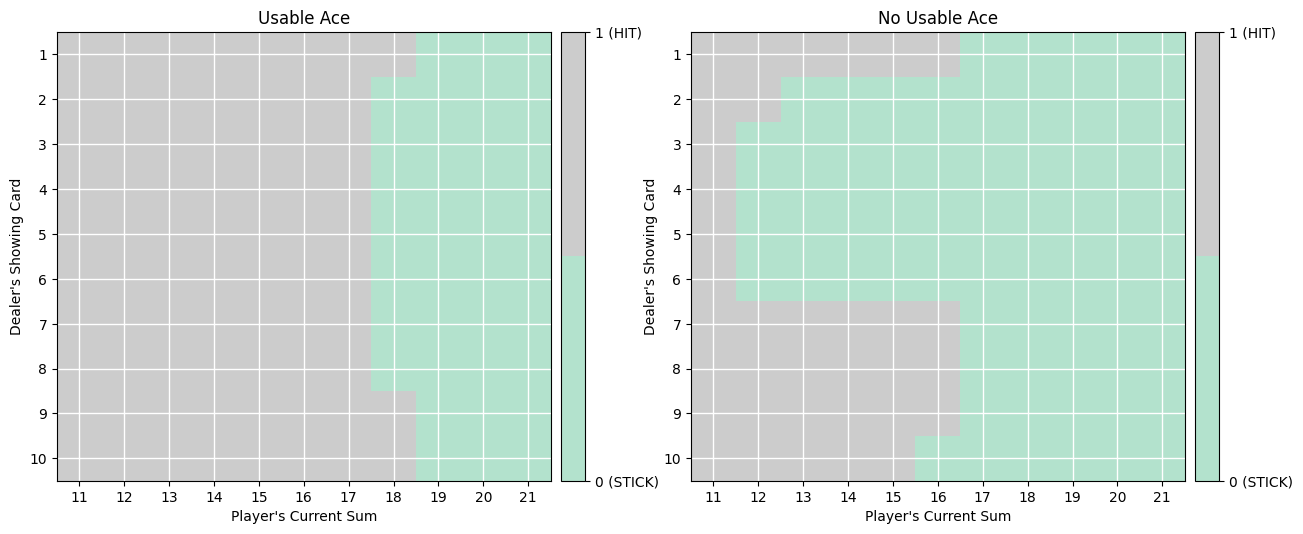

In [6]:
"""
   Monte-Carlo algorithm for Blackjack
   first-visit implementation

"""

Q = defaultdict(lambda: np.zeros(env.action_space.n))
returns_sum = defaultdict(float)
returns_count = defaultdict(float)

# Epsilon-greedy policy
def epsilon_greedy_policy(state):
    if np.random.rand() < epsilon:
        return np.random.randint(env.action_space.n)
    return np.argmax(Q[state])

# Monte Carlo learning
for episode in range(num_episodes):
    episode_memory = []
    state, _ = env.reset()

    while True:
        action = epsilon_greedy_policy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode_memory.append((state, action, reward))
        state = next_state
        if terminated or truncated:
            break

    G = 0
    visited = set()
    for state, action, reward in reversed(episode_memory):
        G = gamma * G + reward
    if (state, action) not in visited:
            visited.add((state, action))
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1.0
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
            
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
#    if episode > 1_000_000:
#        epsilon = max(0.01, epsilon * epsilon_decay)
    
# Derive final policy
policy = {state: np.argmax(actions) for state, actions in Q.items()}

plot_policy(policy)

In [7]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def show_frames_grid(frames, max_frames=9, cols=5):
    n = min(len(frames), max_frames)
    rows = (n + cols - 1) // cols

#    plt.figure(figsize=(5 * cols, 4 * rows))
    plt.figure(figsize=(17, 9))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(frames[i])
        plt.title(f"Frame {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def create_text_frame(text, width=600, height=400, font_size=60):
    from PIL import Image, ImageDraw, ImageFont
    import numpy as np

    # Create blank white canvas
    img = Image.new('RGB', (width, height), color='white')
    draw = ImageDraw.Draw(img)

    # Try to load a scalable font, fallback to default
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        try:
            font = ImageFont.truetype("DejaVuSans.ttf", font_size)
        except IOError:
            font = ImageFont.load_default()

    # Calculate centered position using textbbox
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    position = ((width - text_width) // 2, (height - text_height) // 2)

    # Draw the text
    draw.text(position, text, fill="black", font=font)

    return np.array(img)

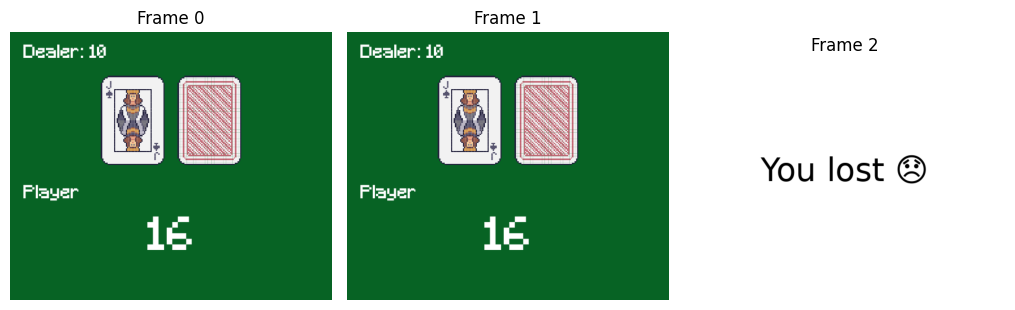

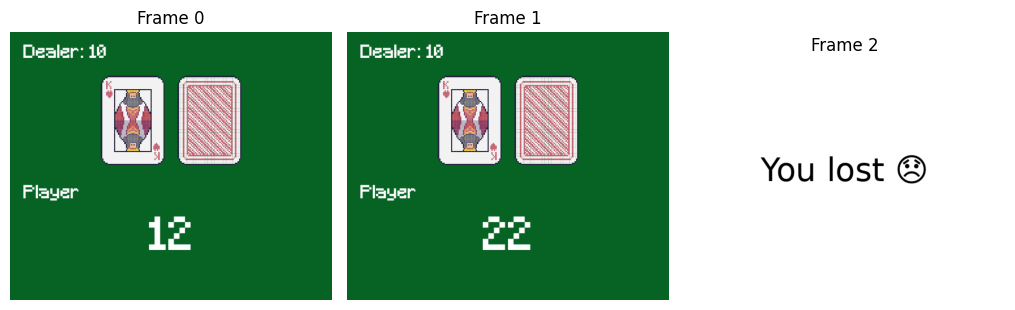

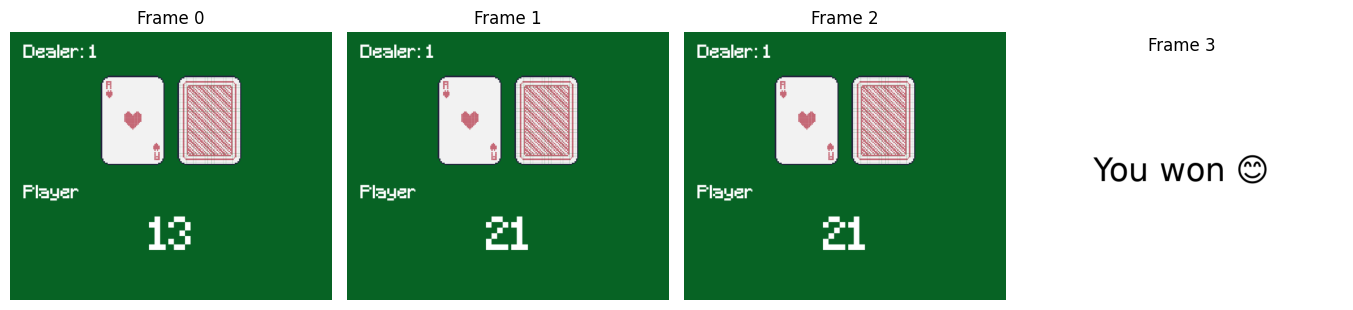

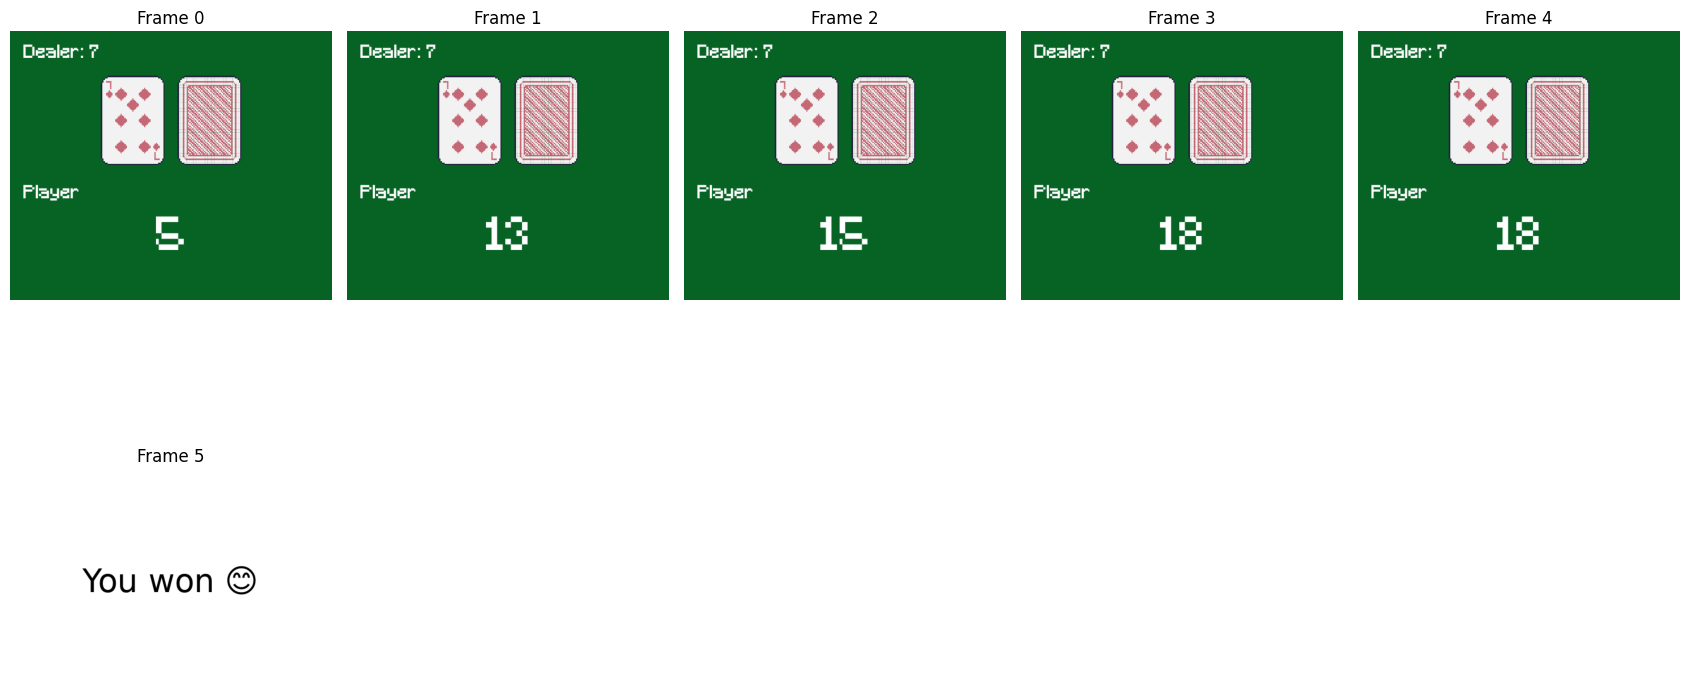

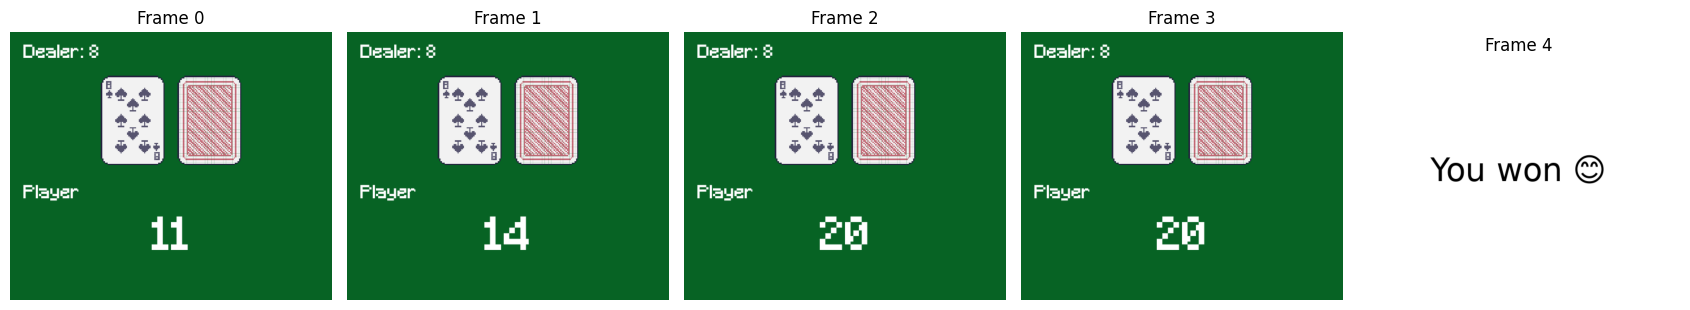

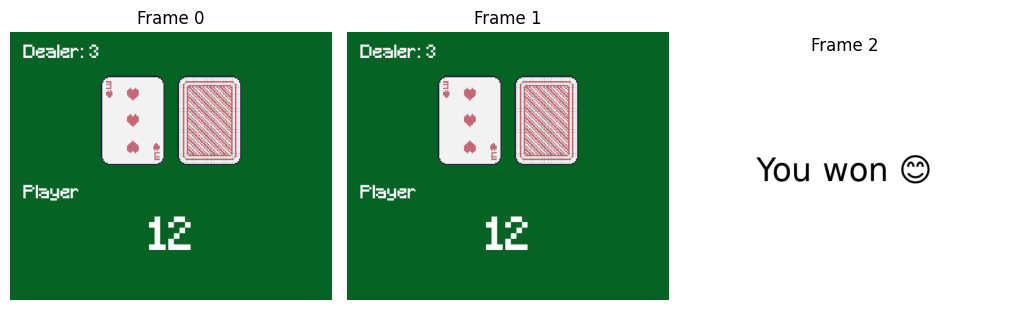

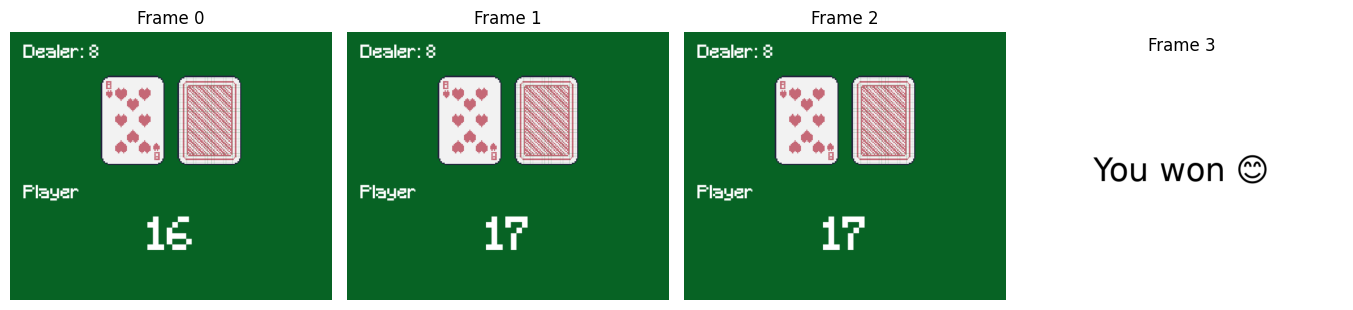

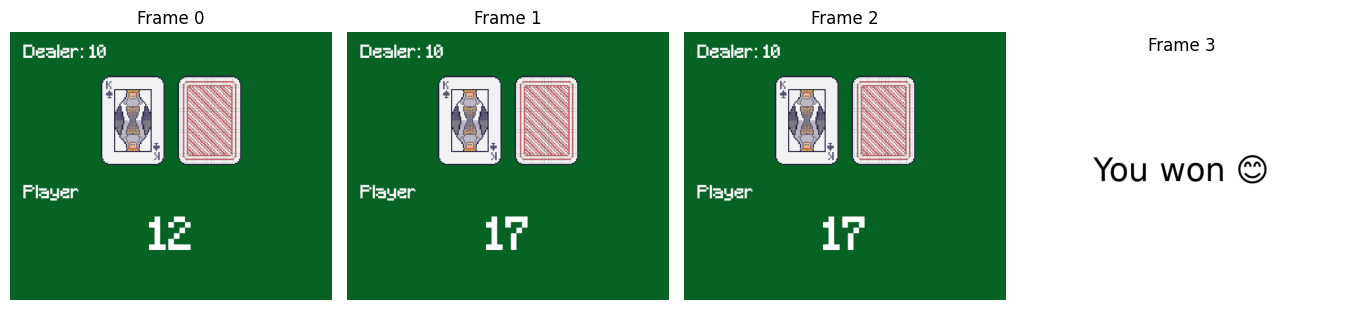

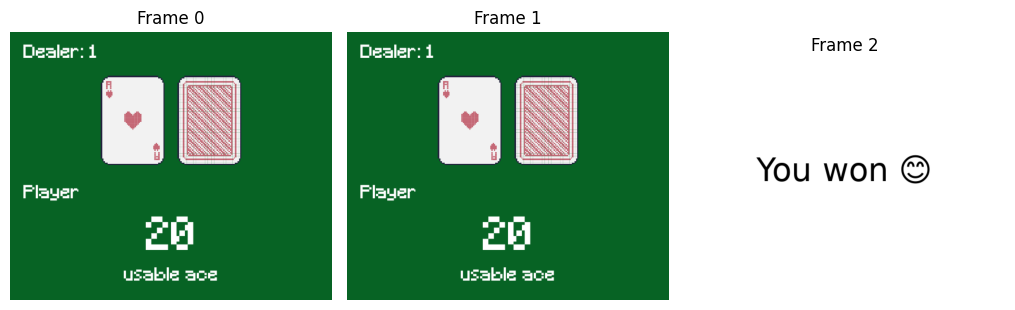

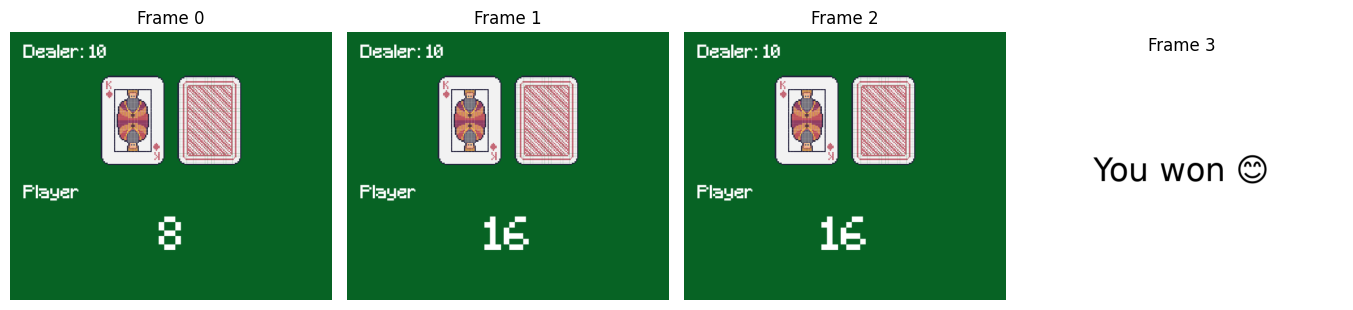

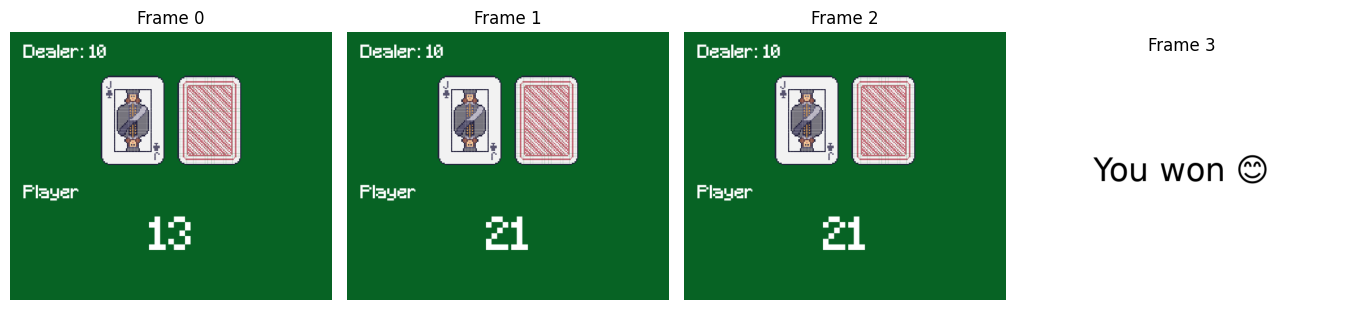

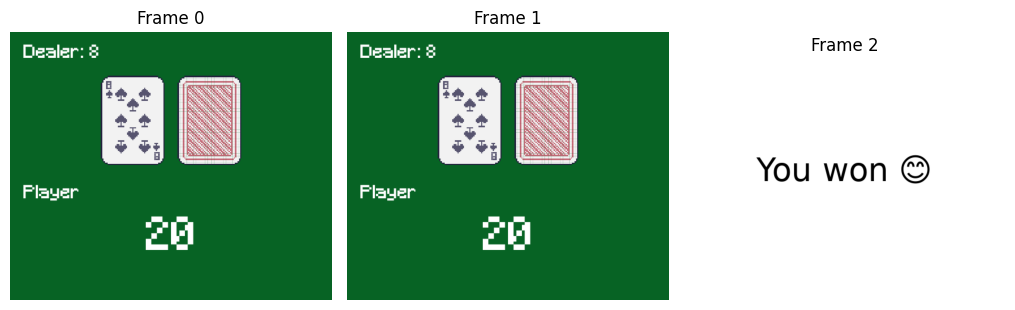

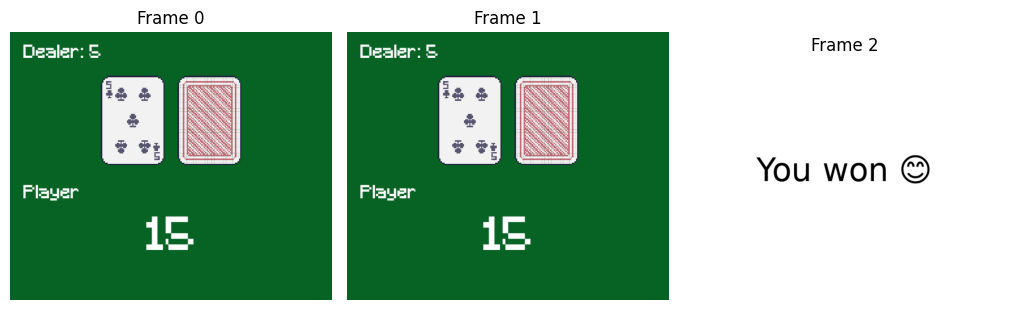

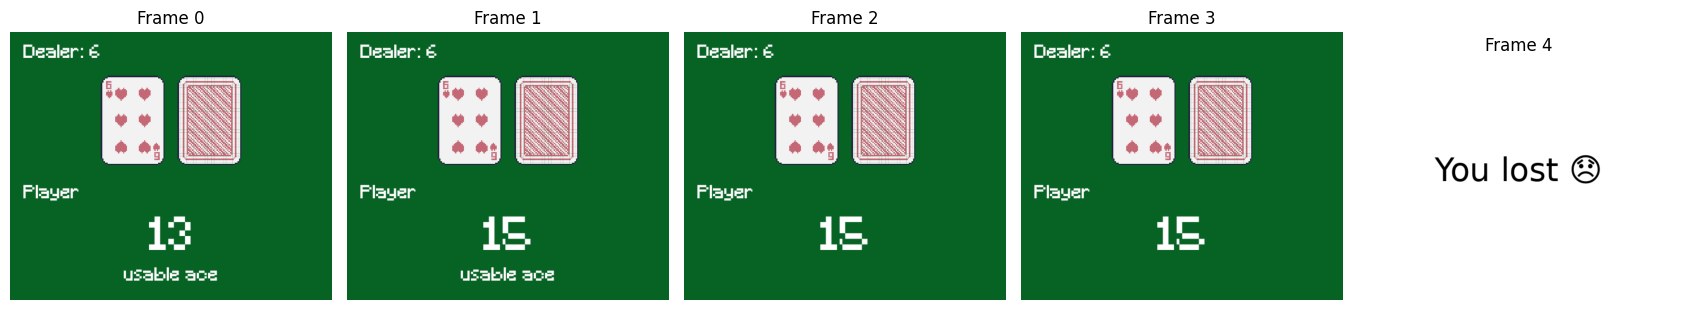

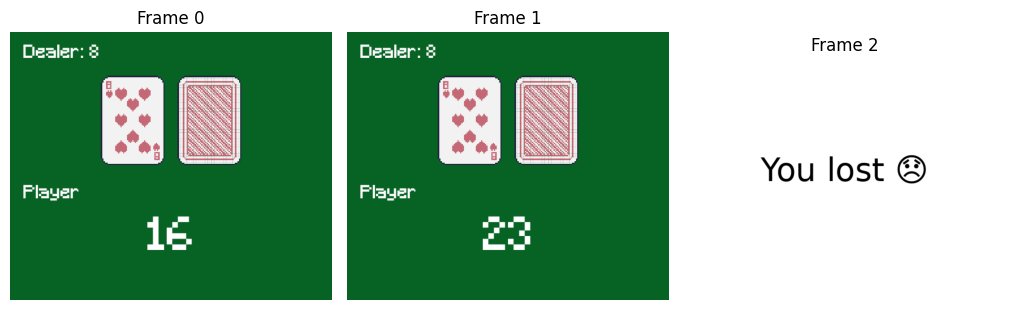

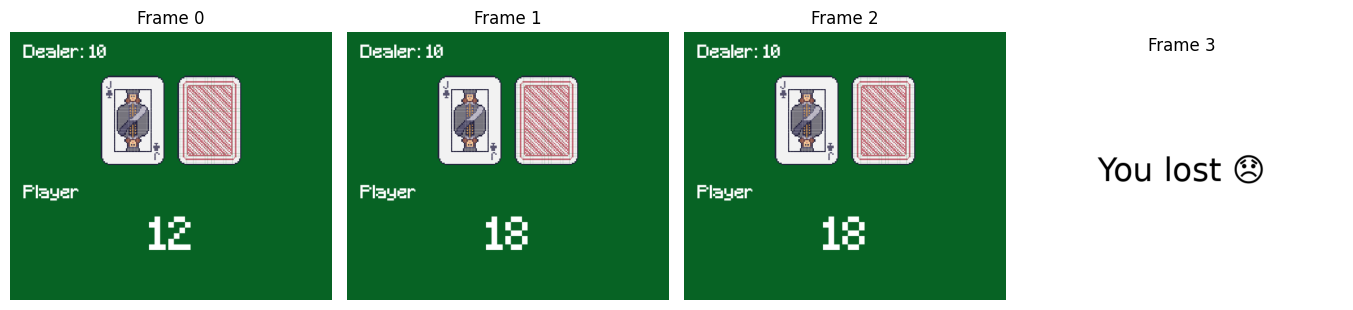

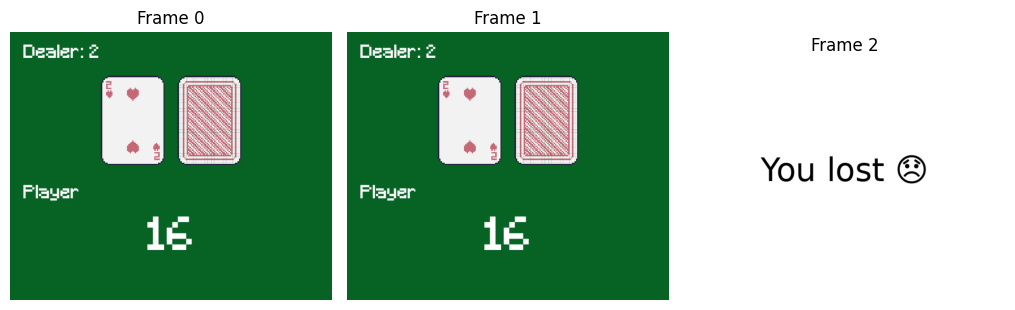

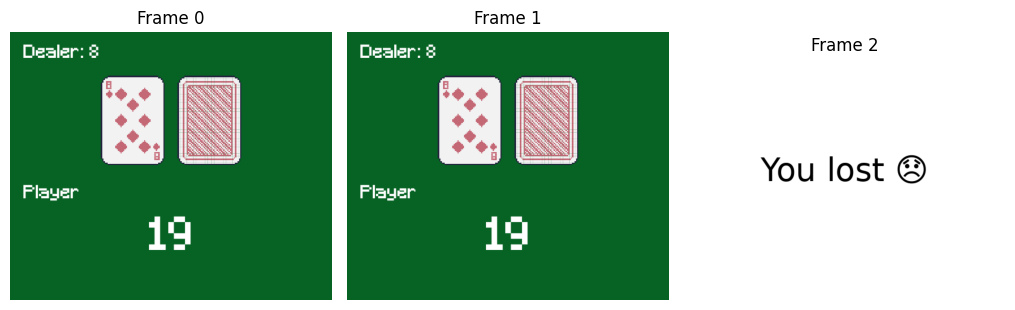

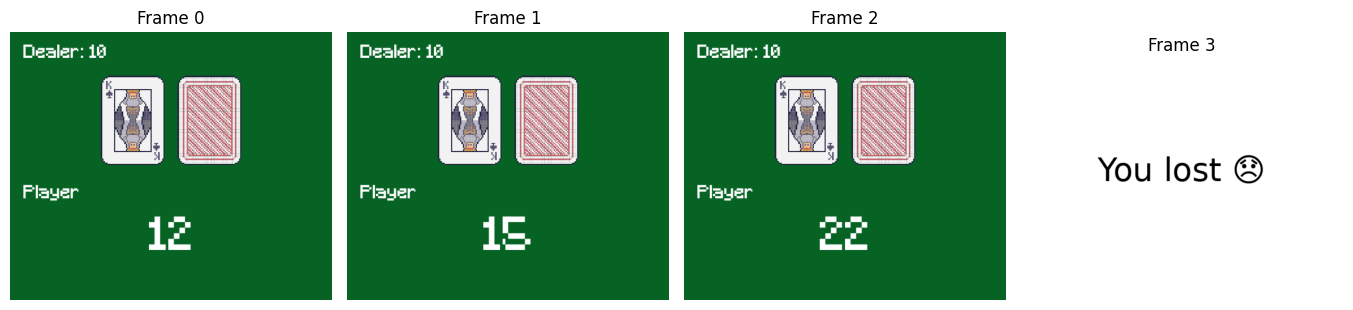

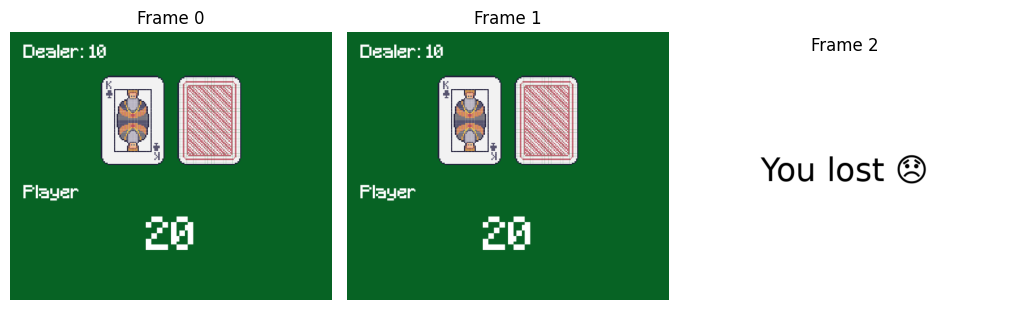

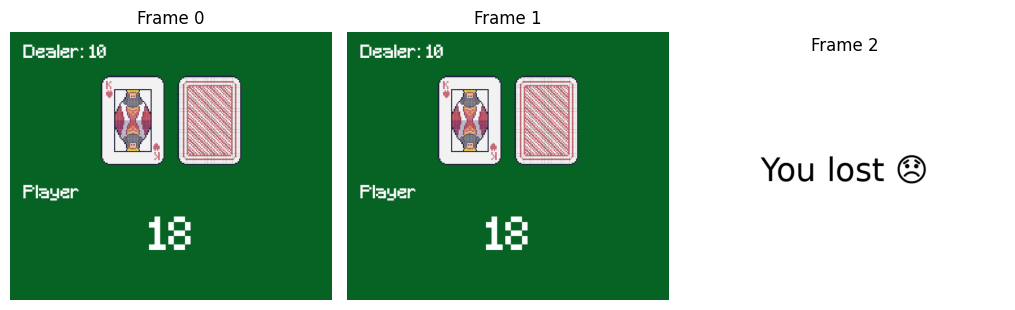

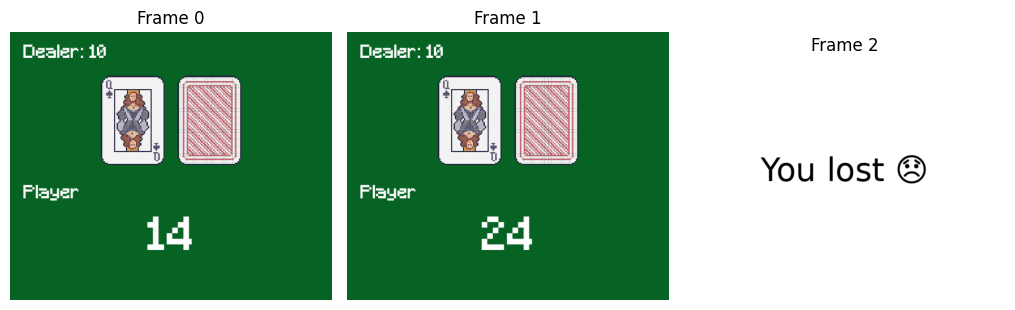

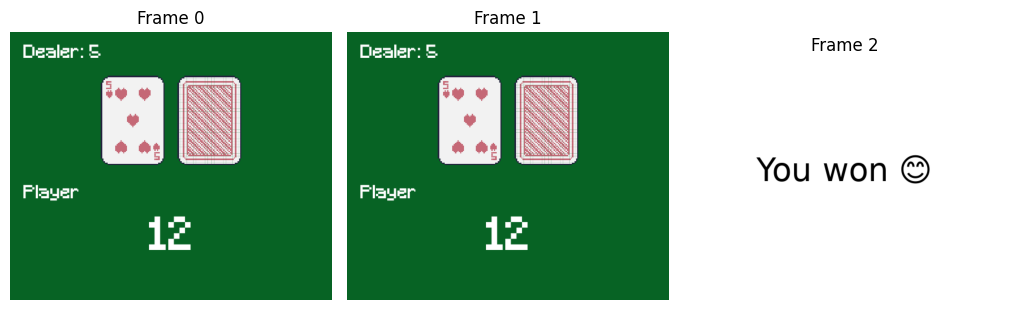

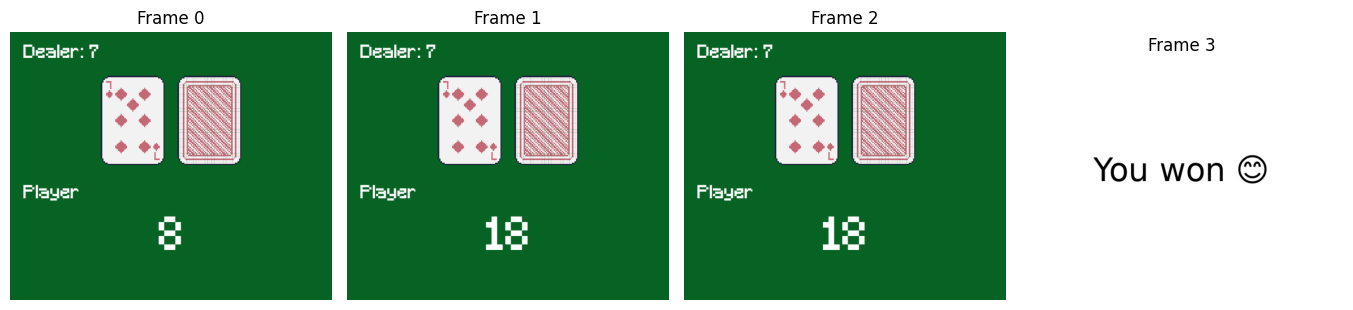

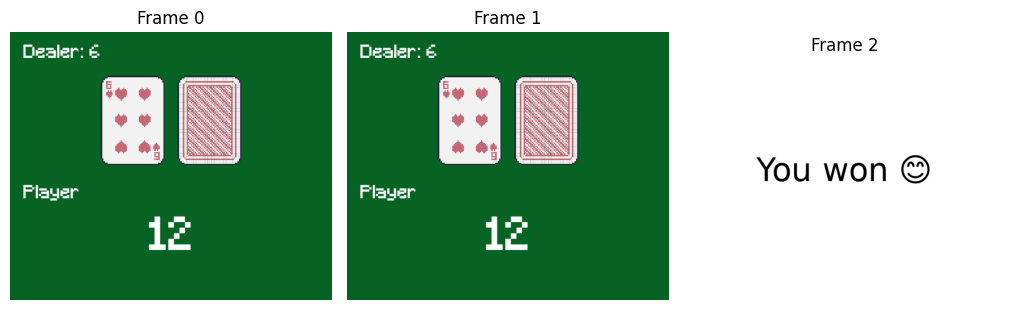

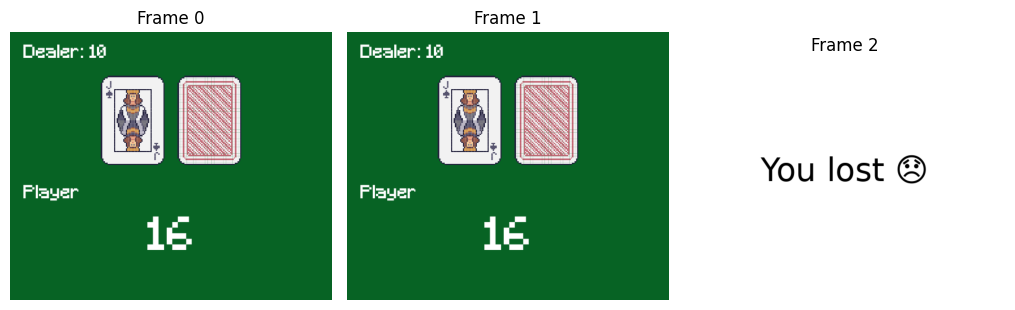

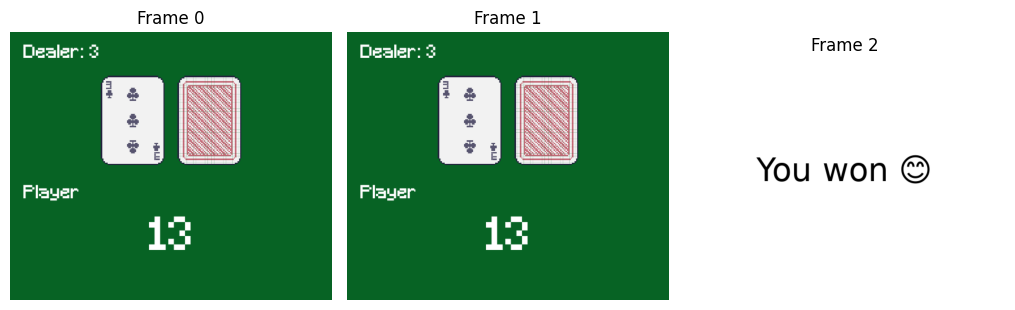

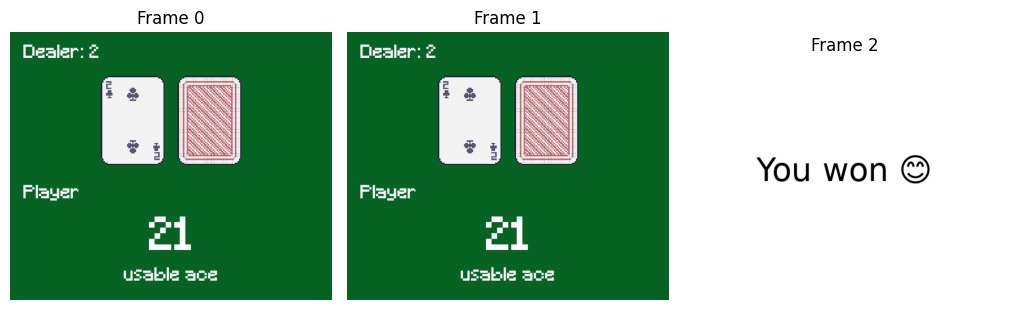

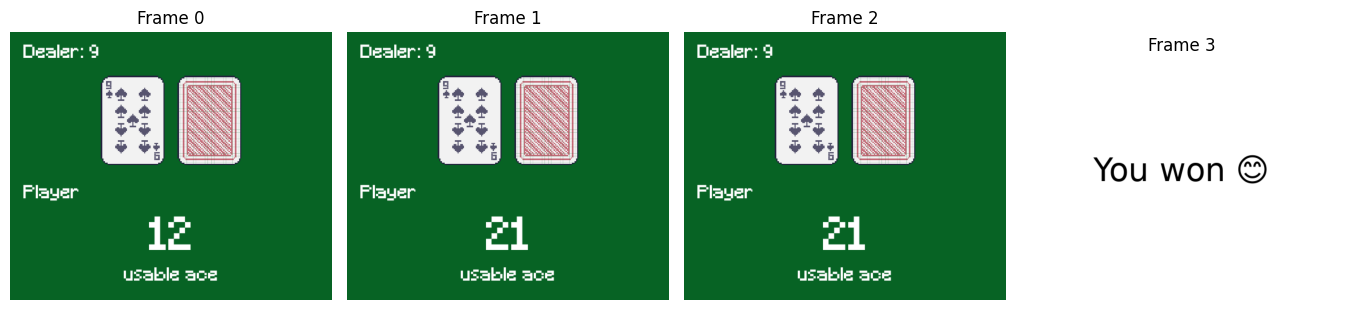

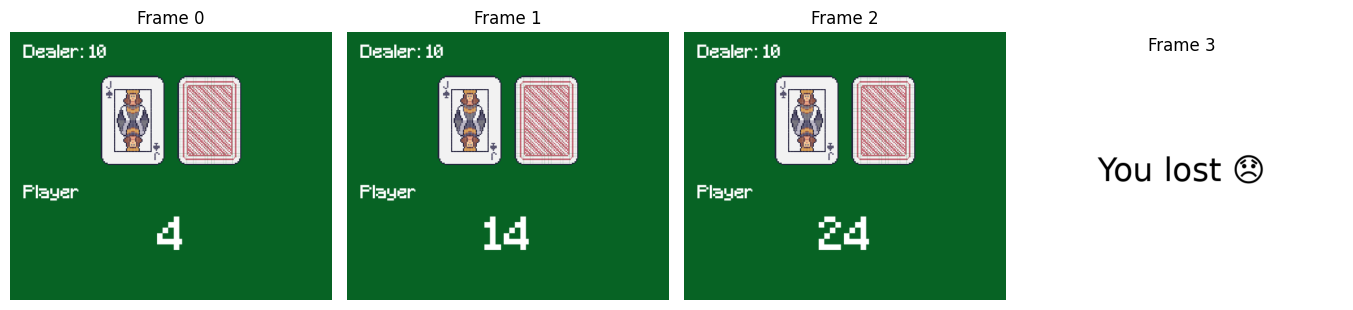

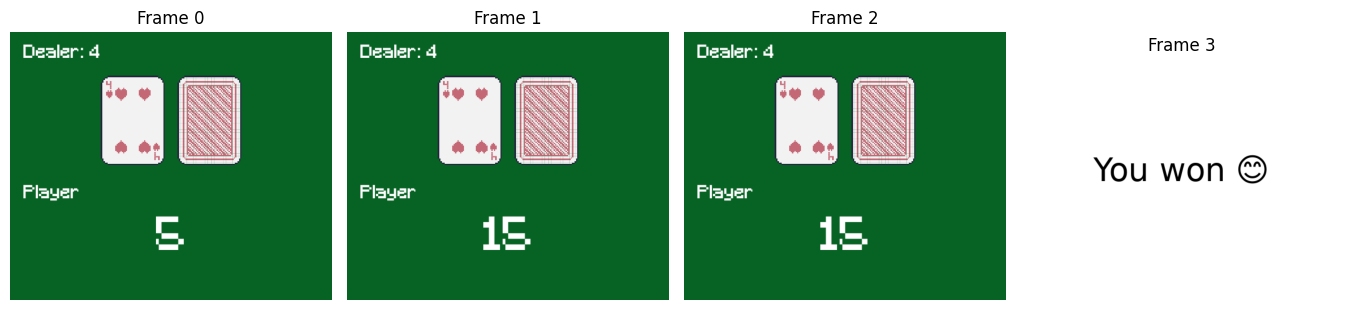

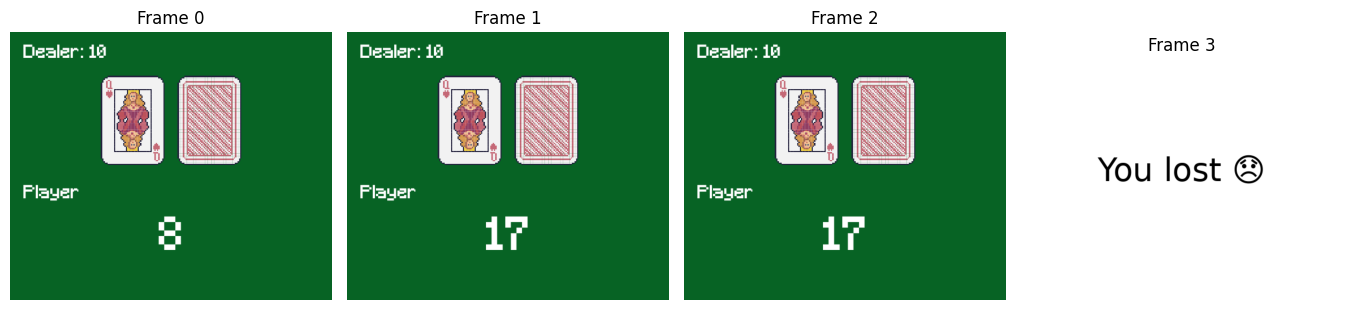

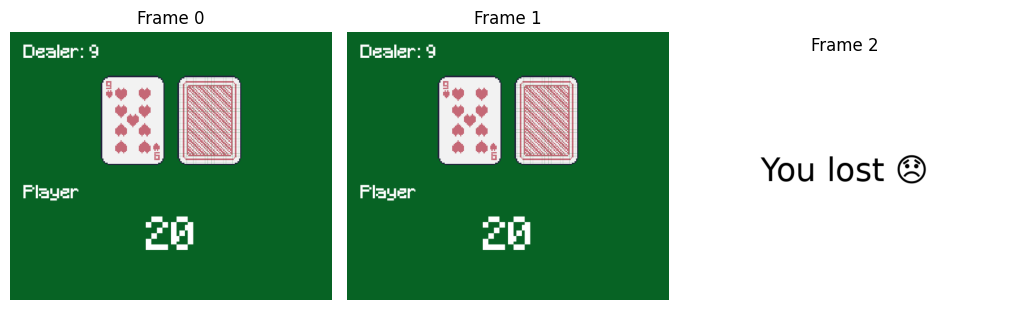

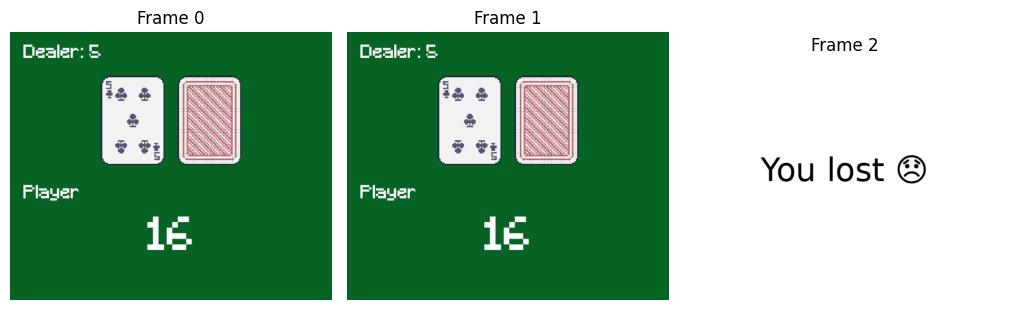

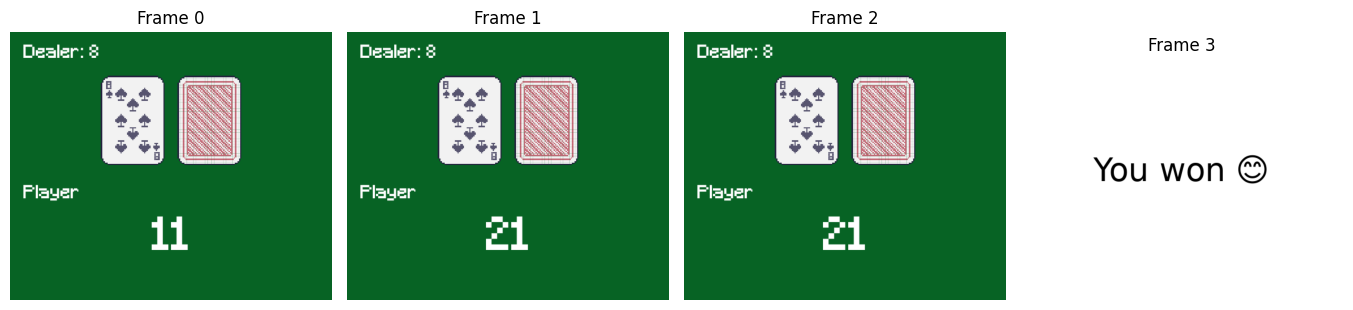

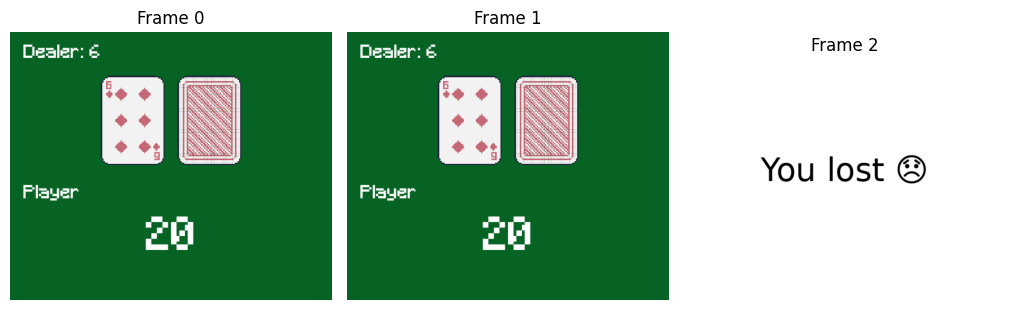

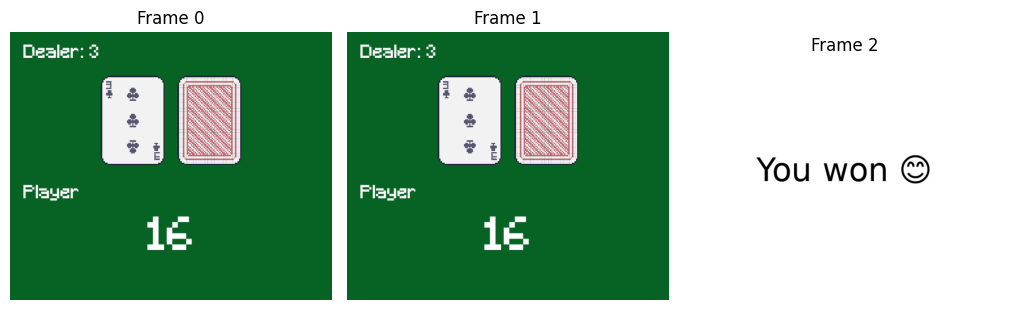

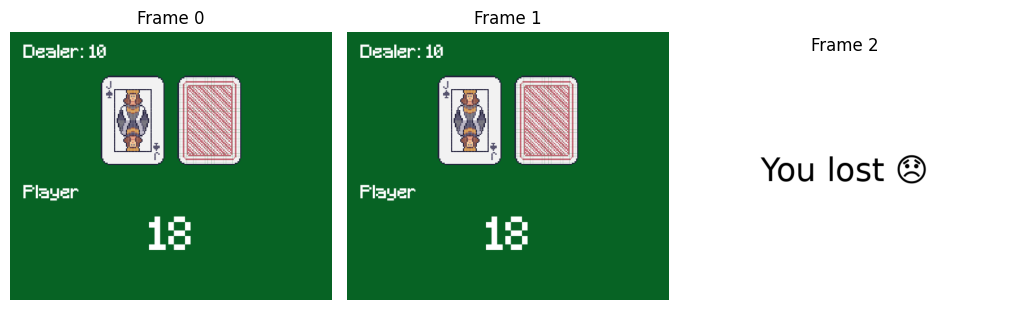

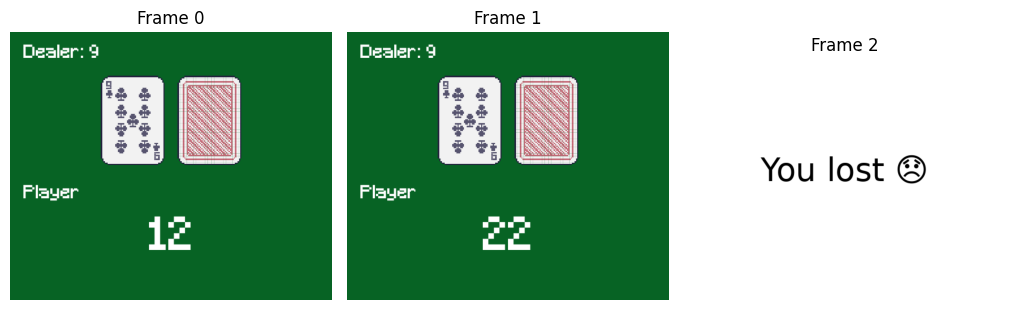

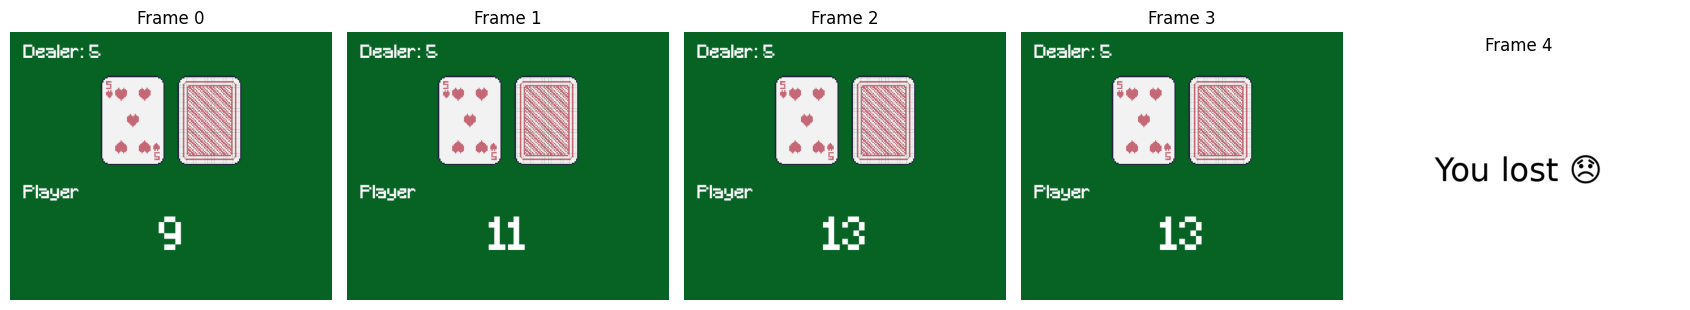

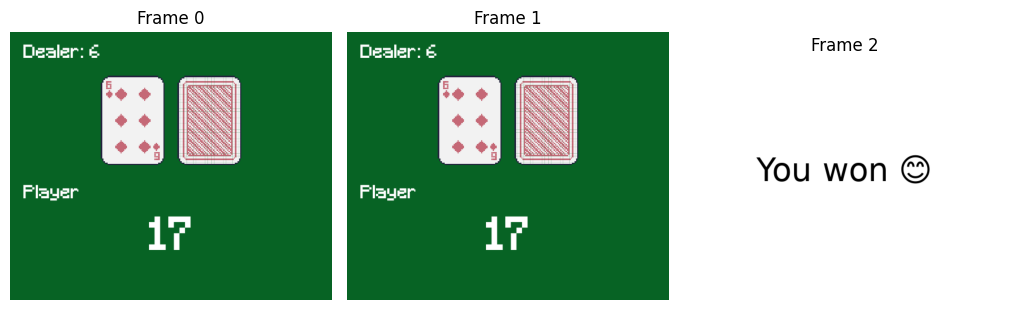

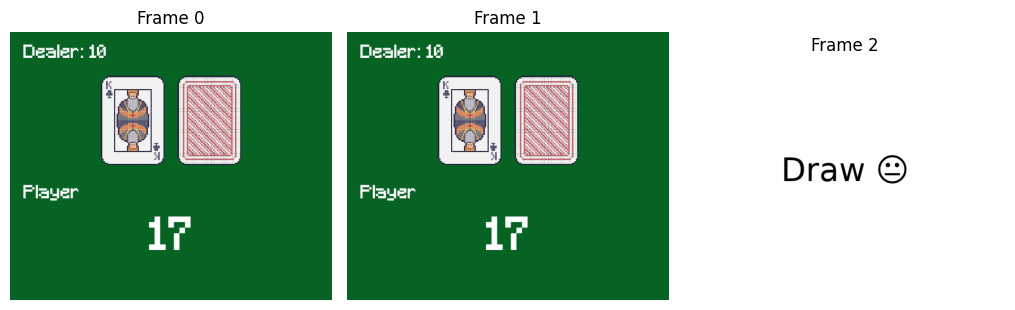

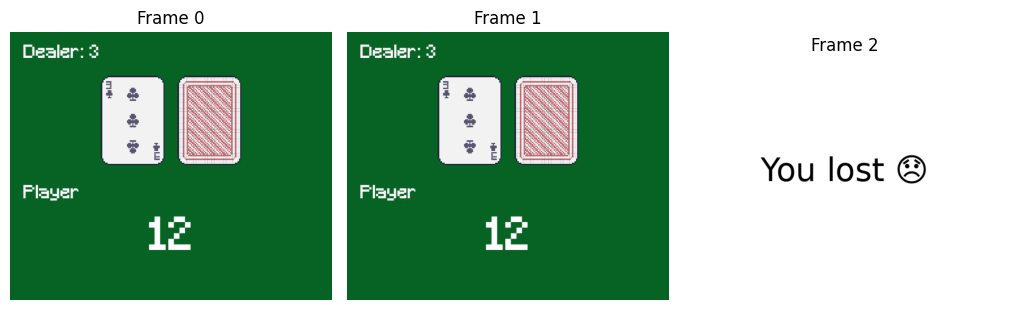

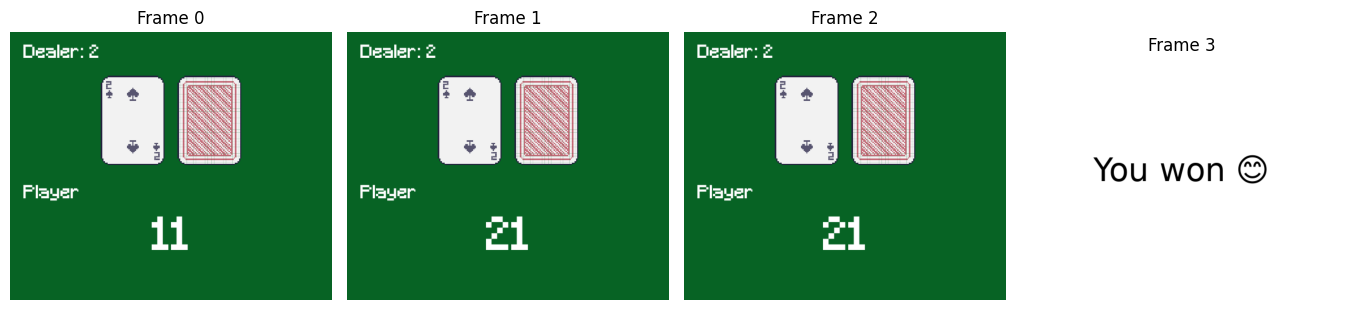

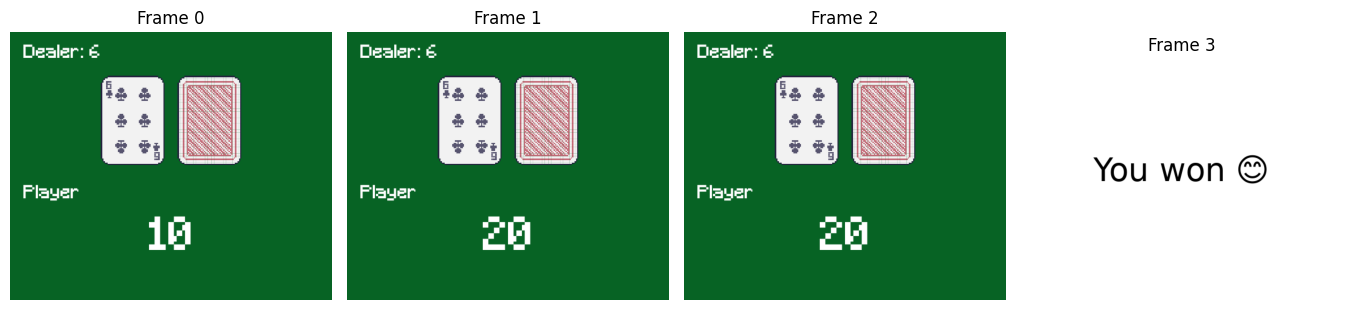

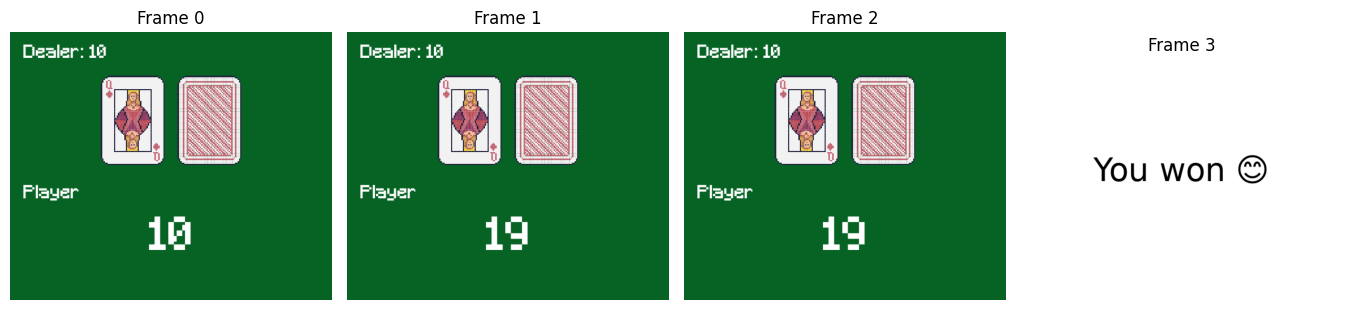

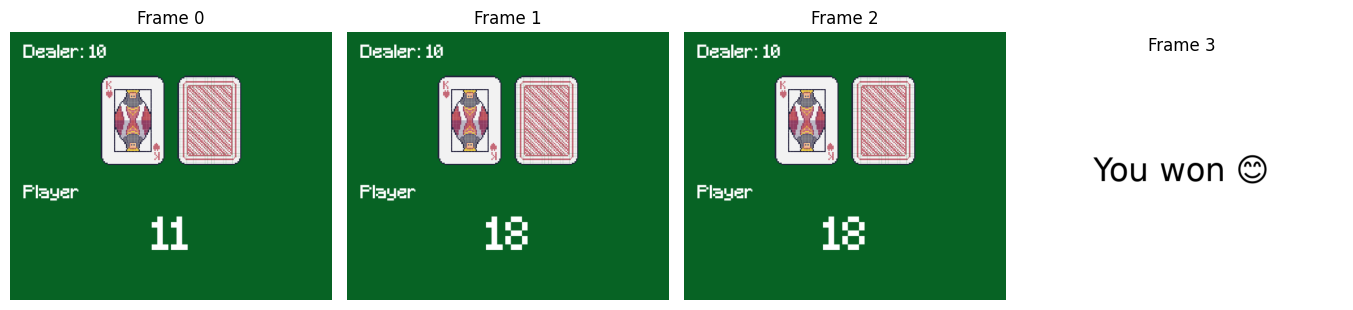

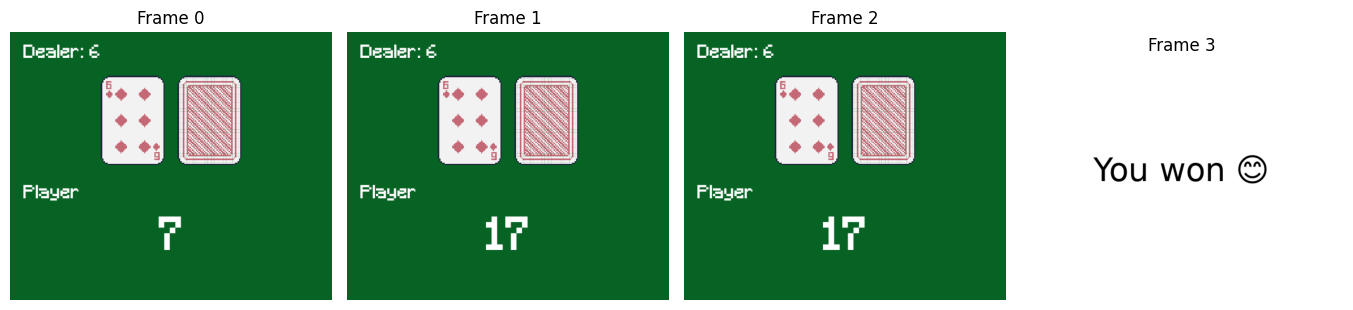

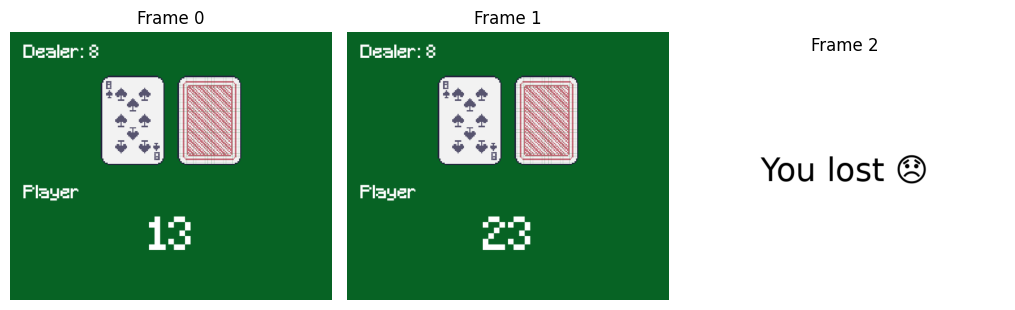

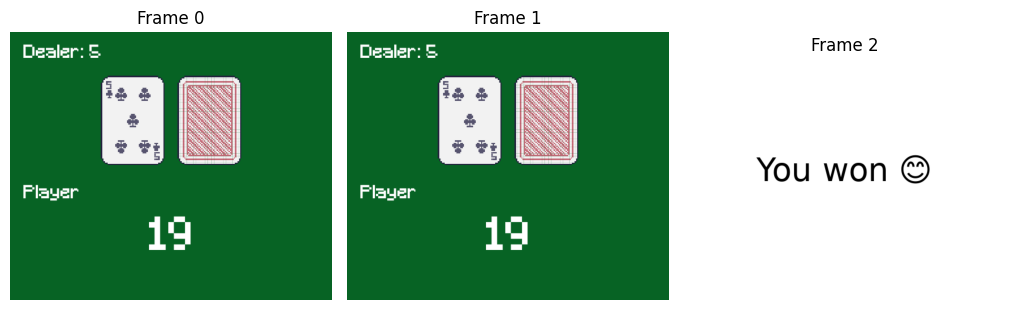

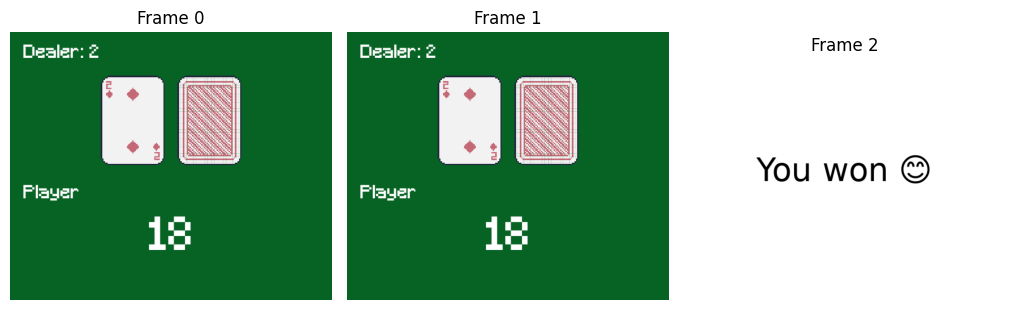

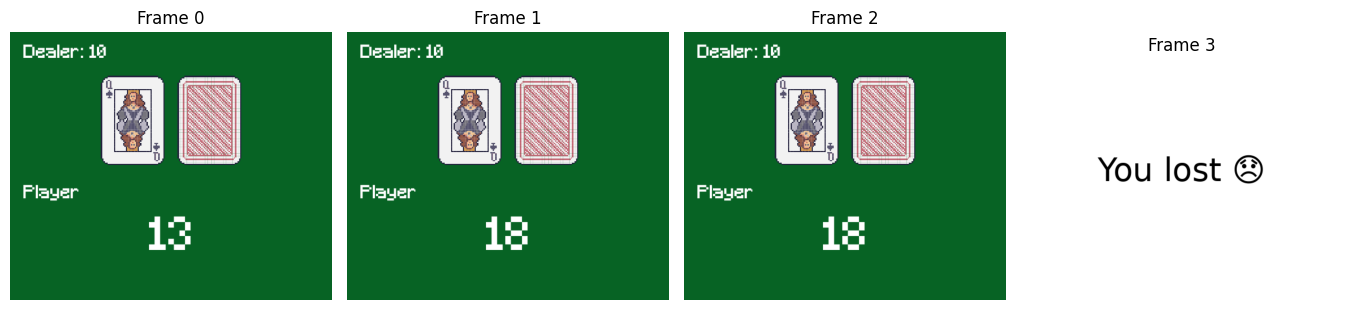

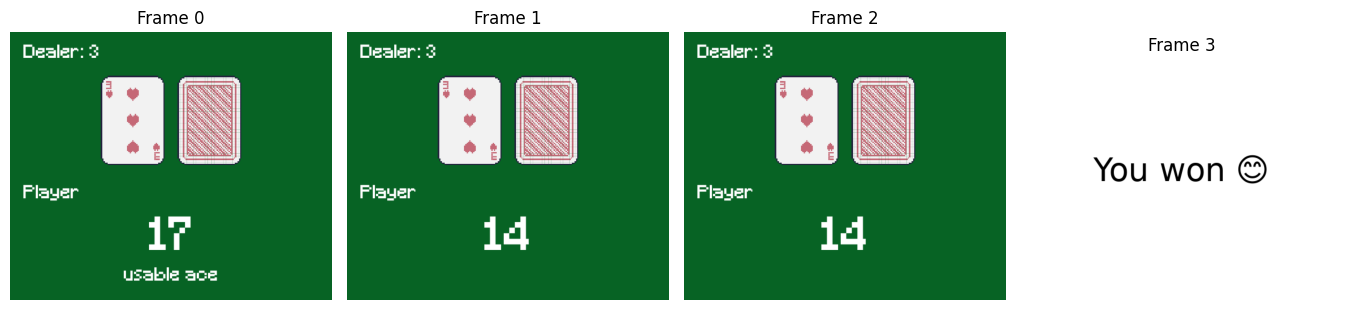

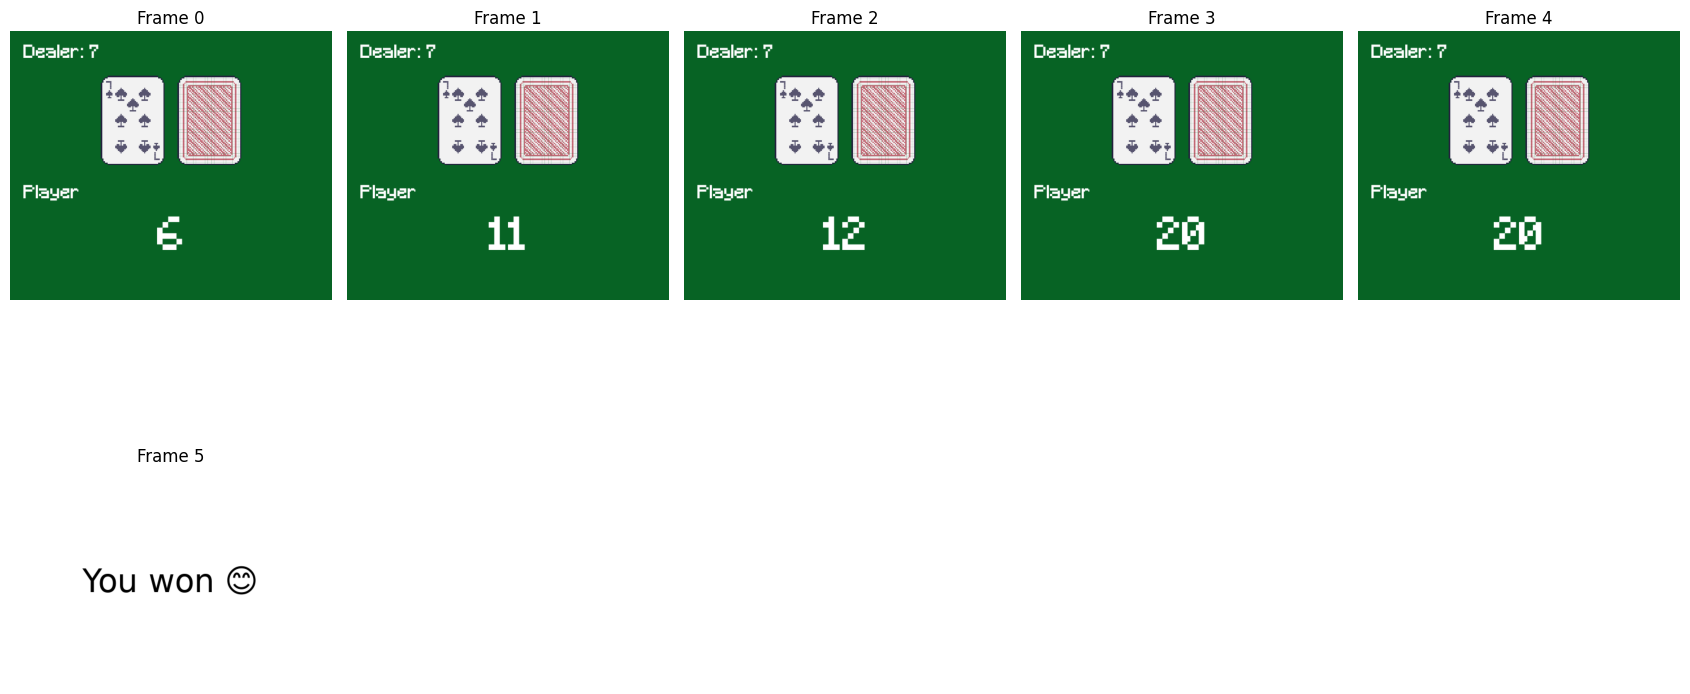

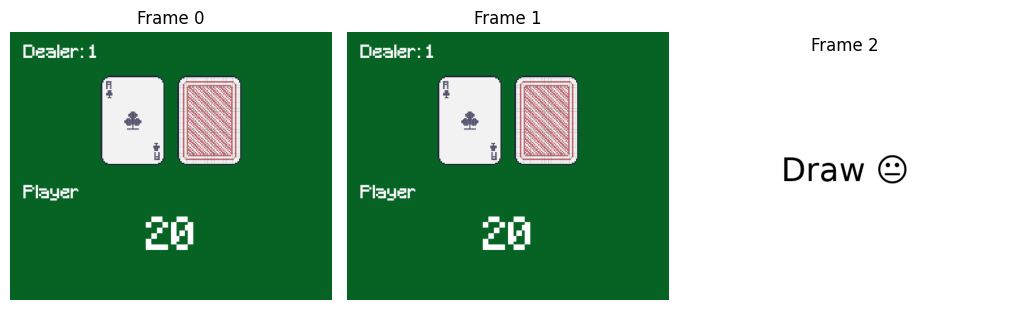

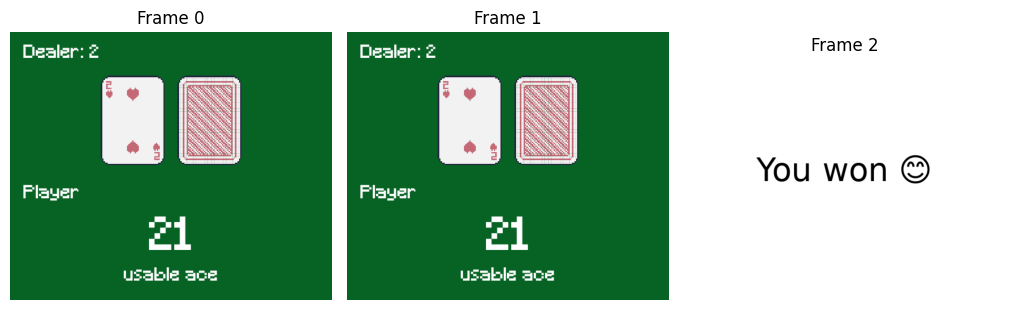

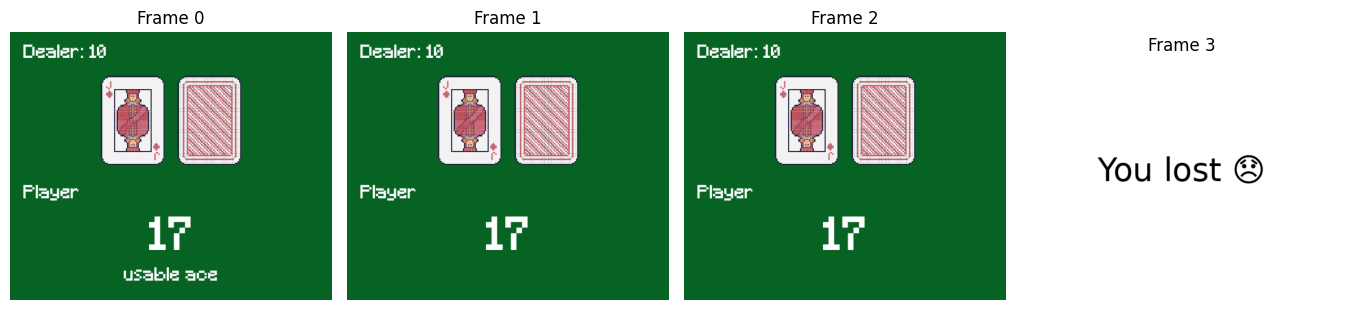

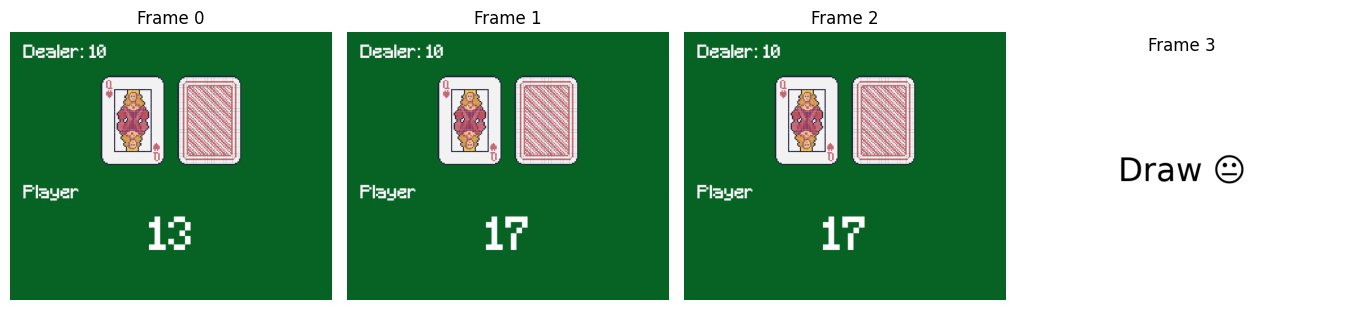

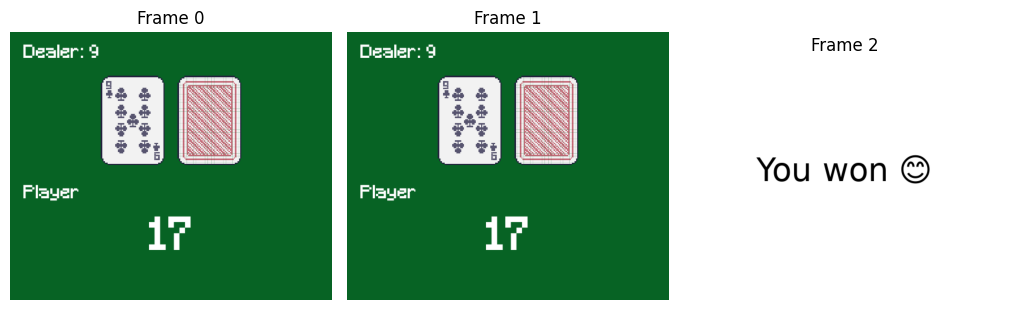

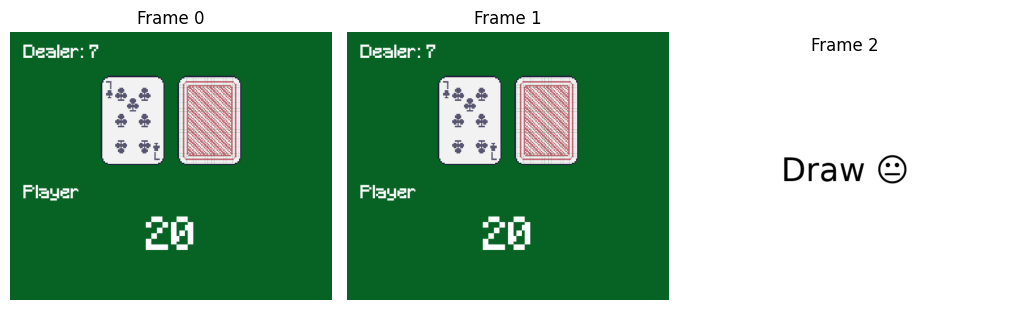

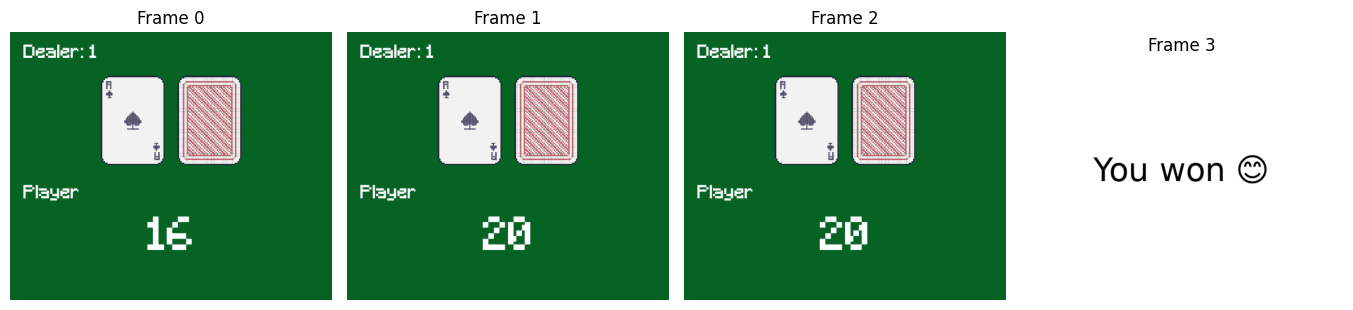

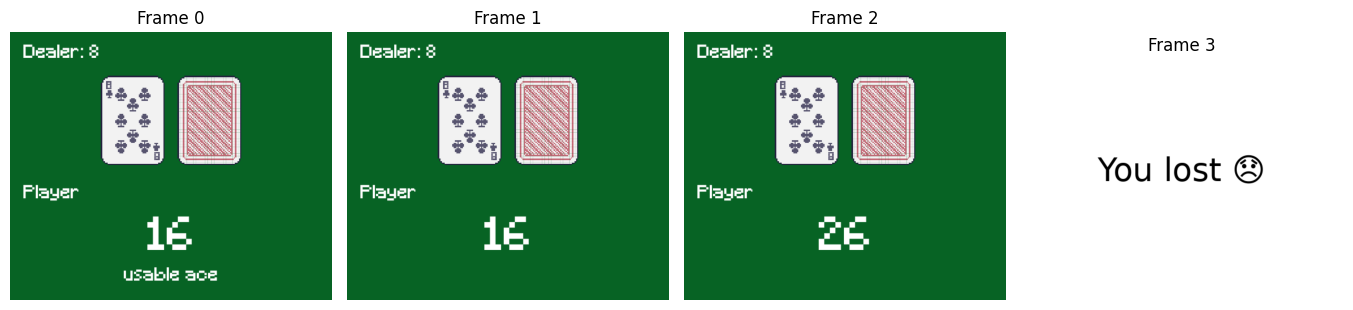

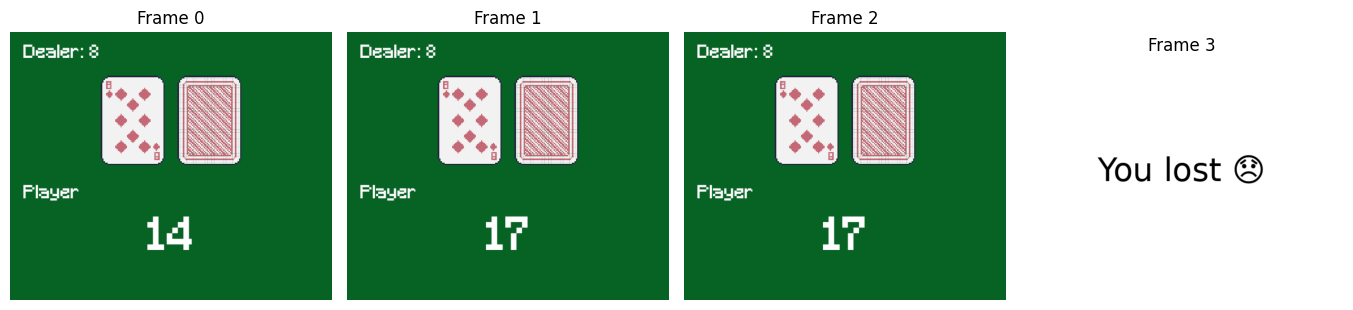

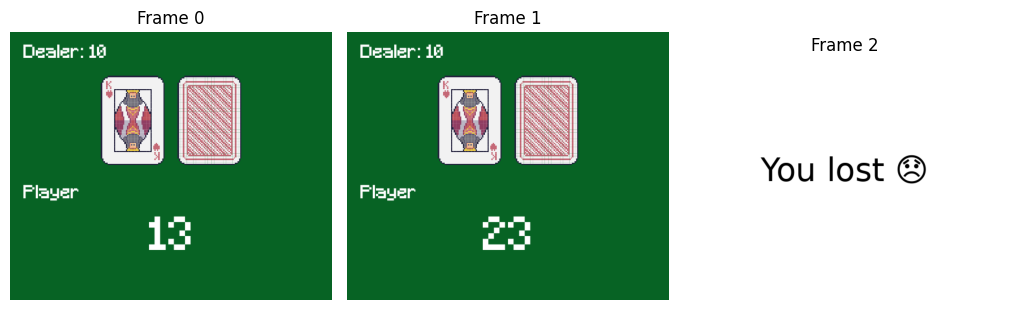

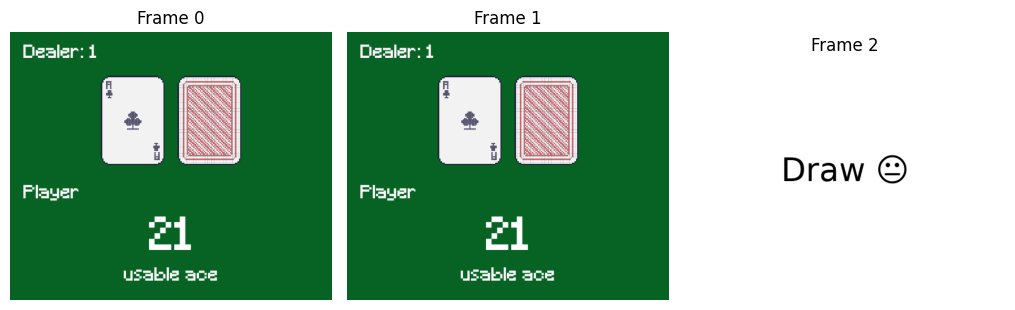

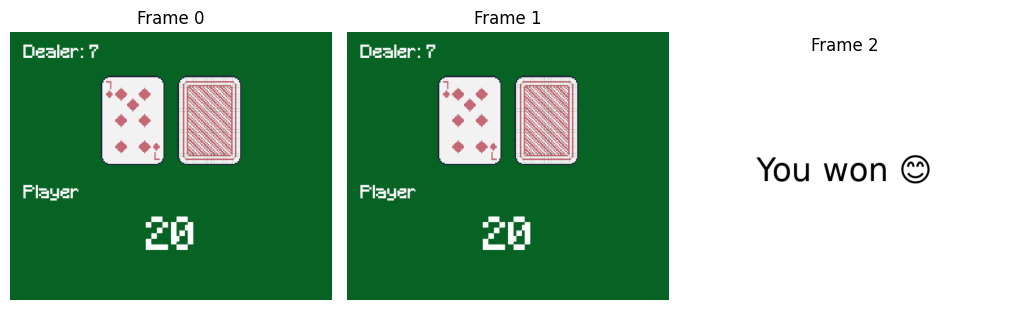

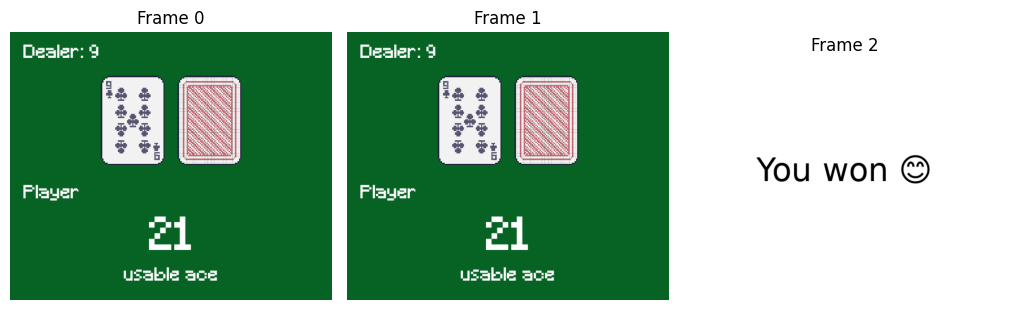

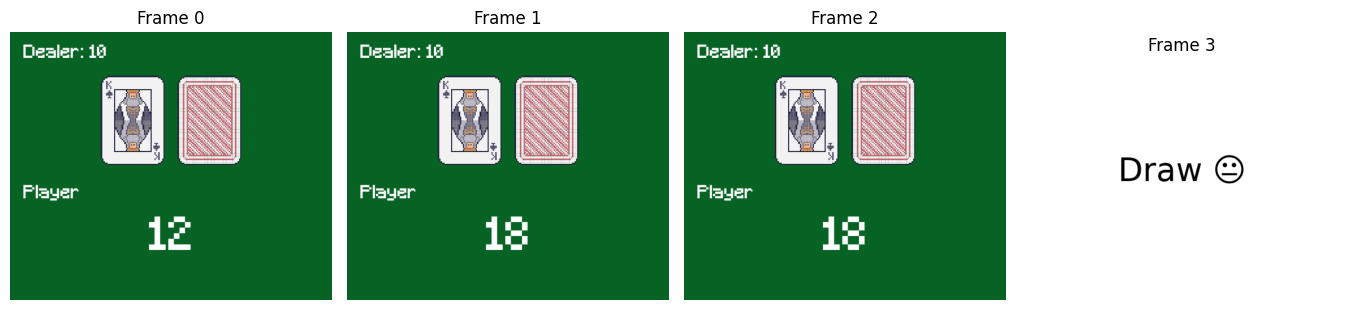

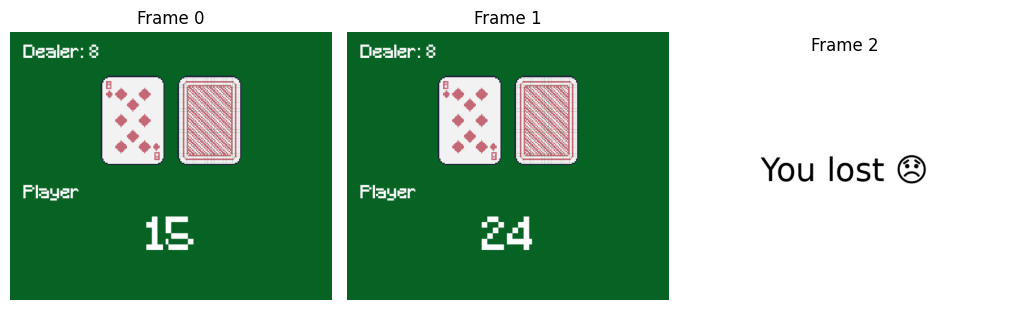

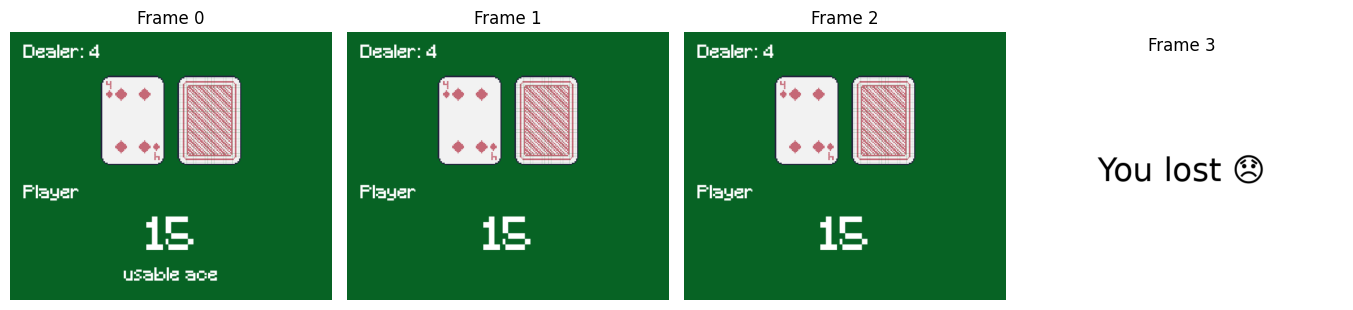

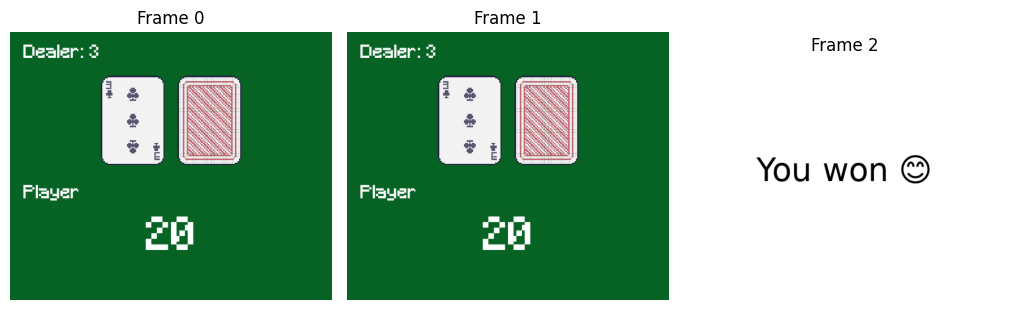

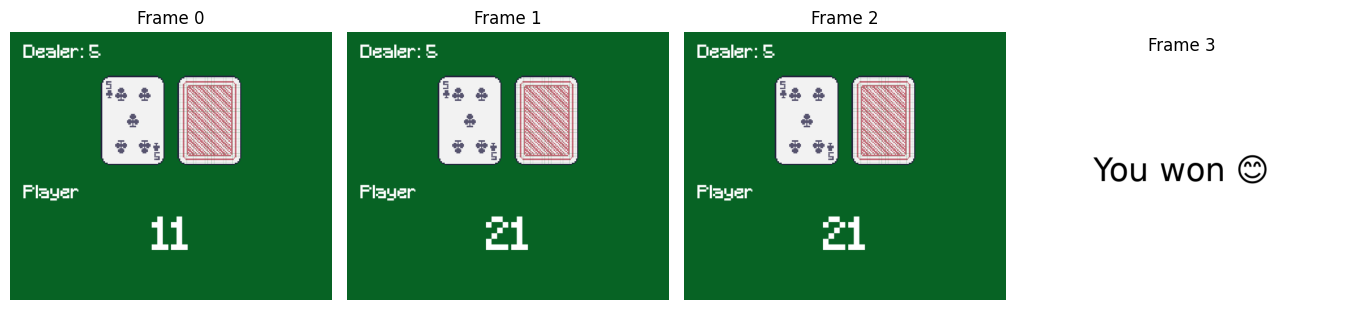

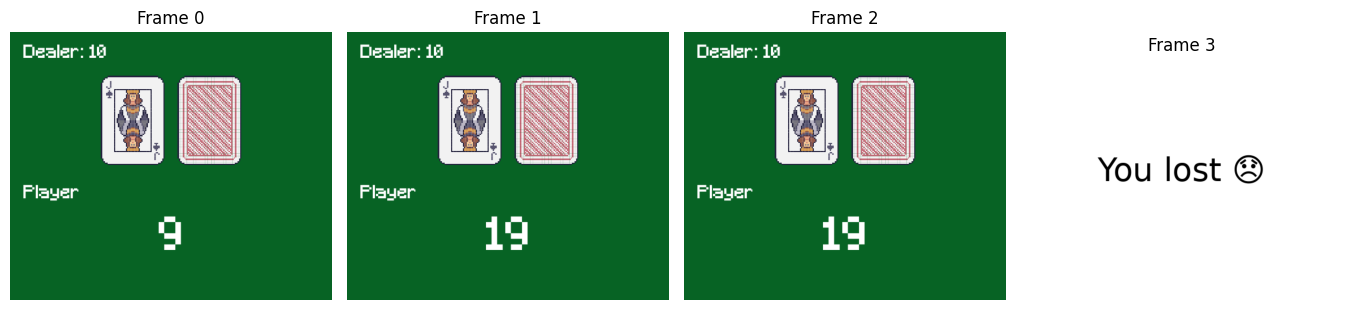

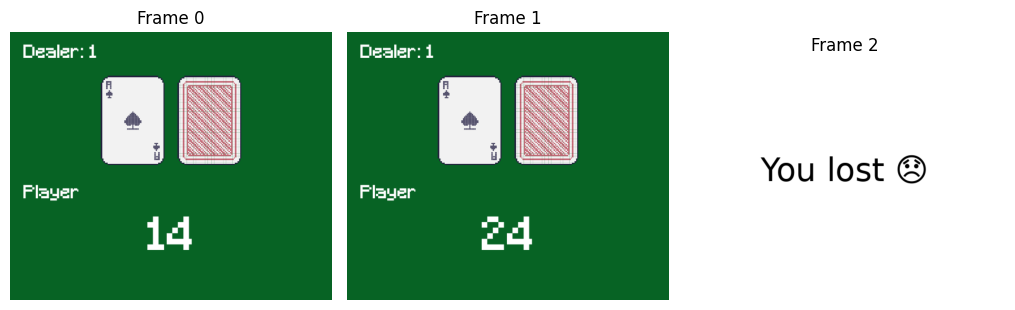

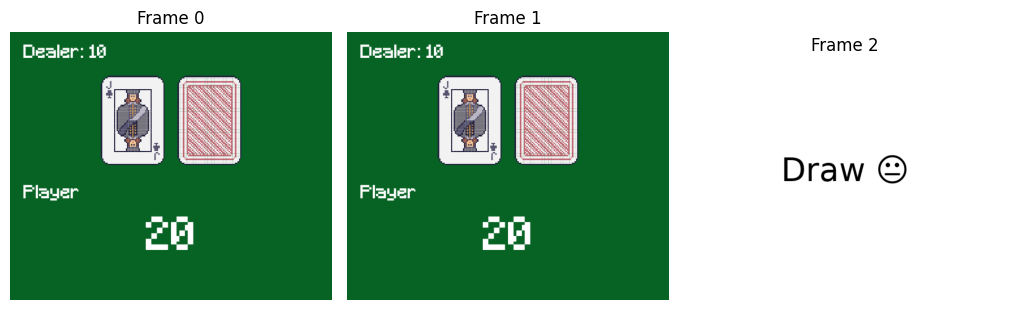

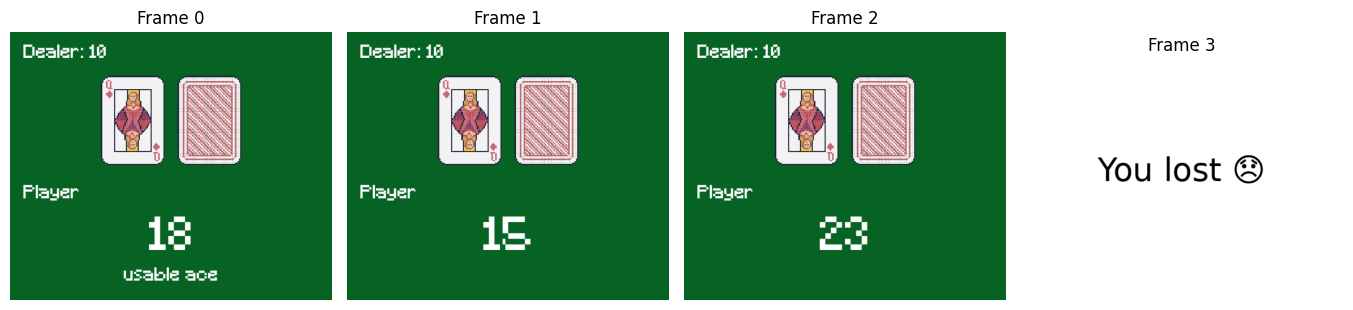

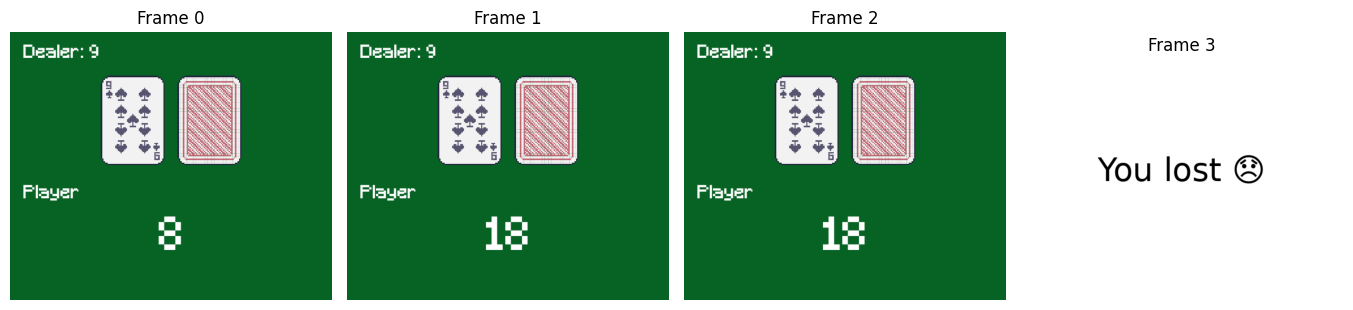

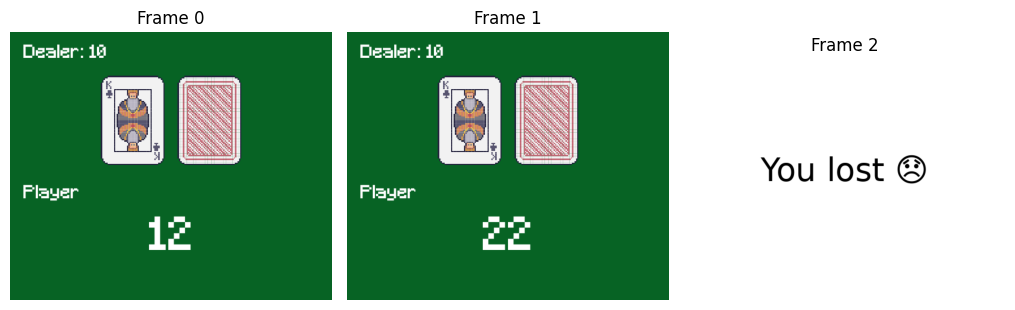

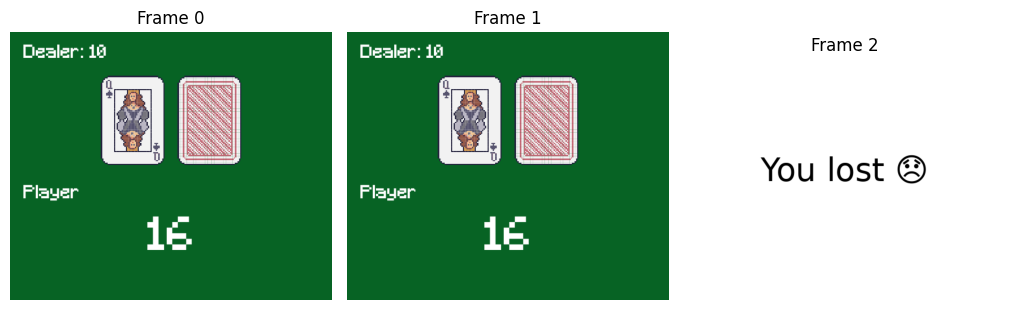

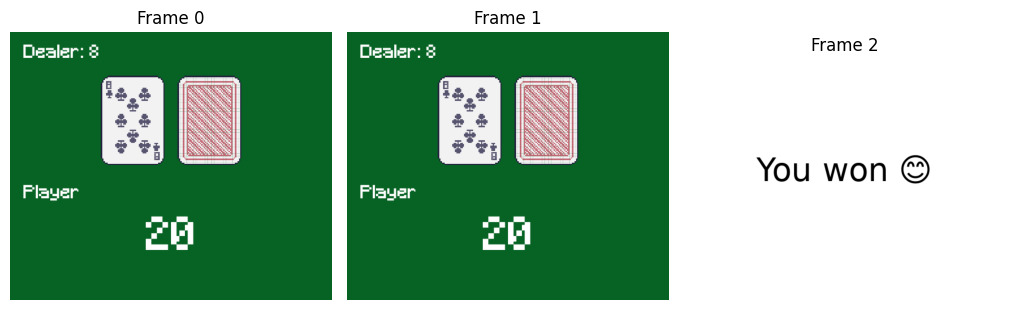

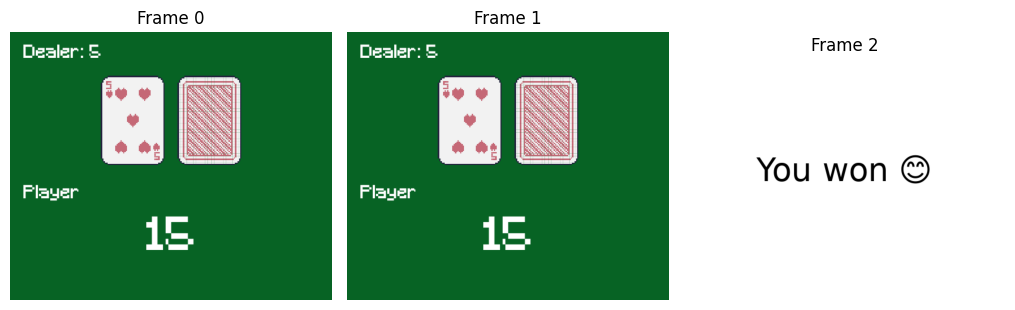

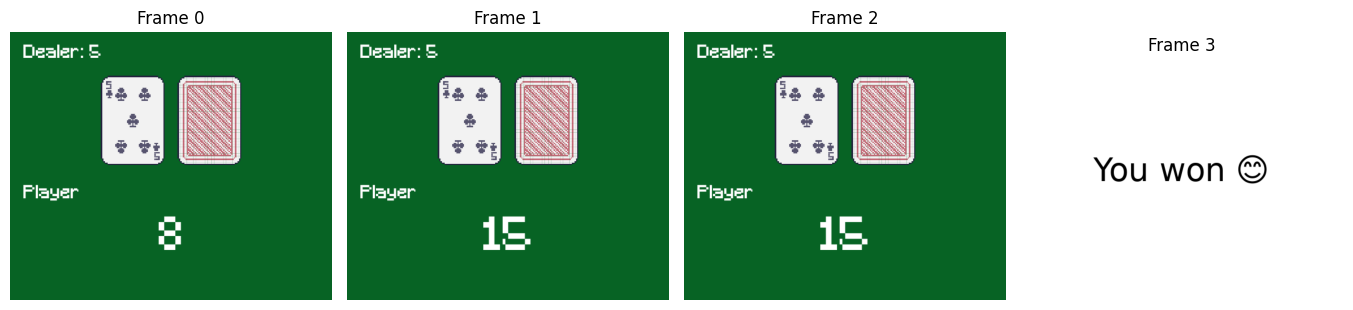

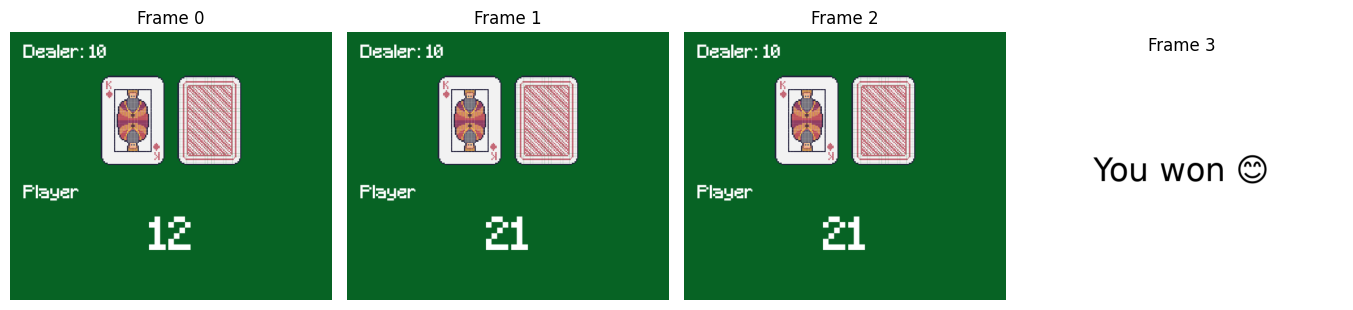

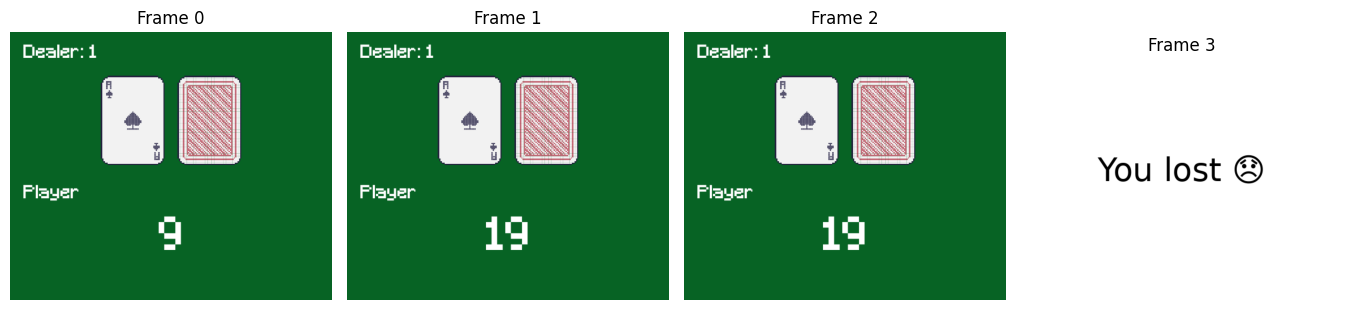

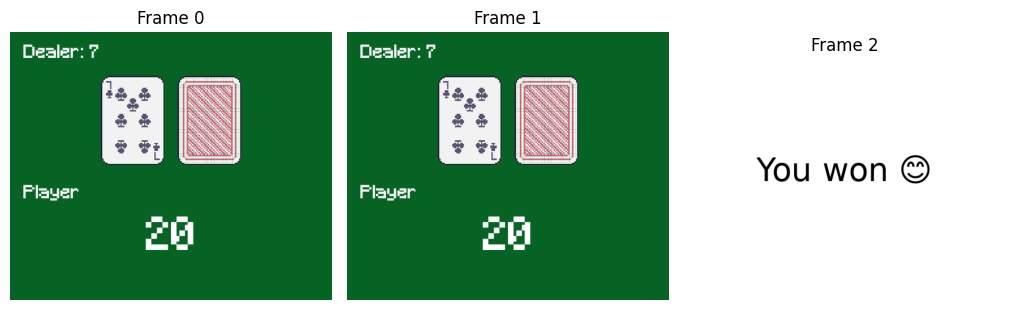

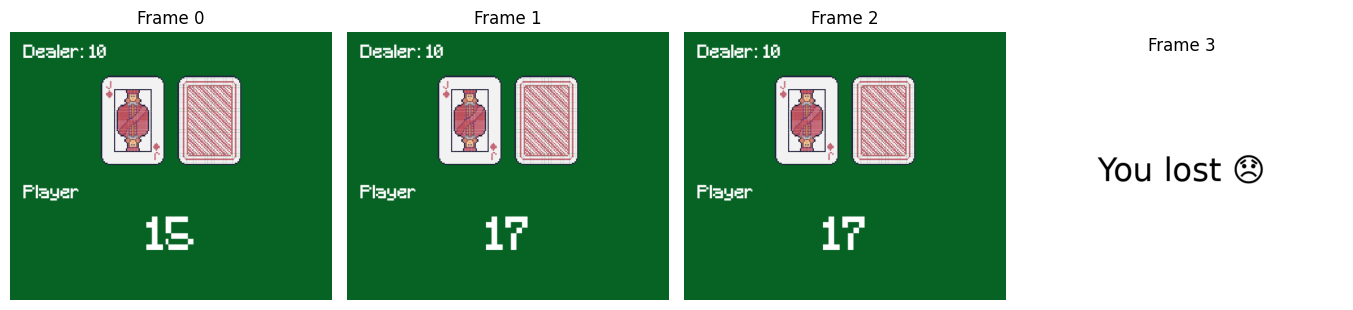

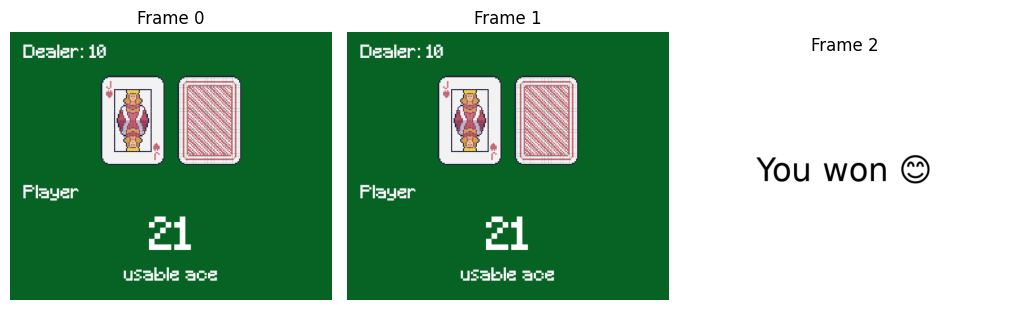

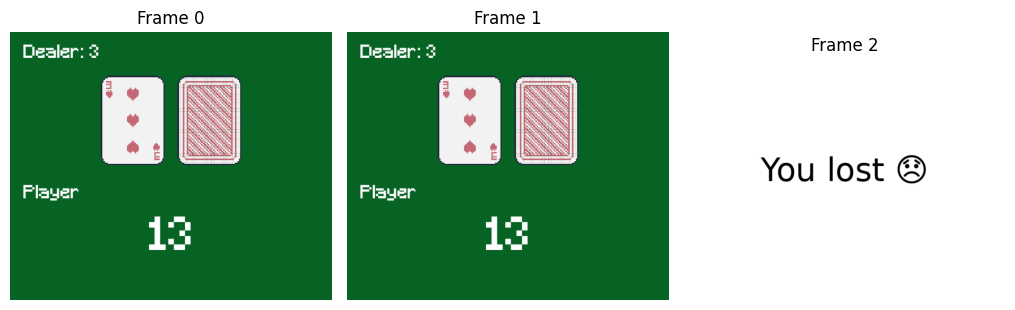

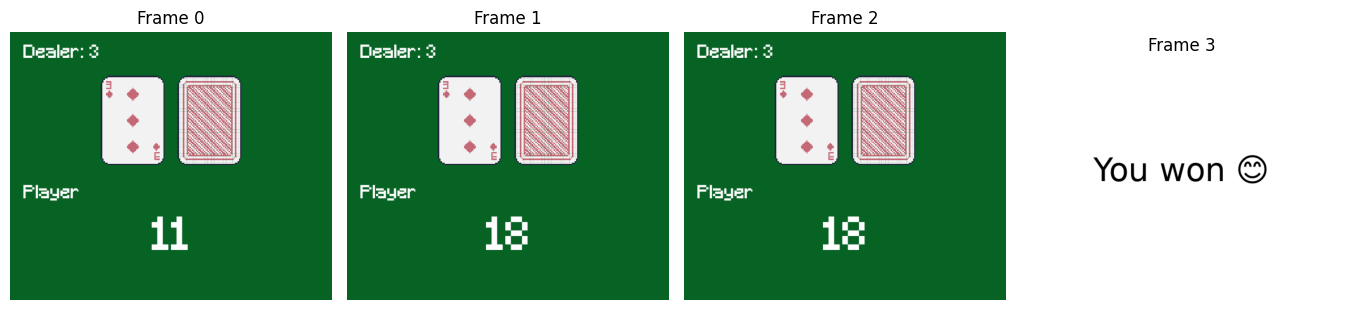

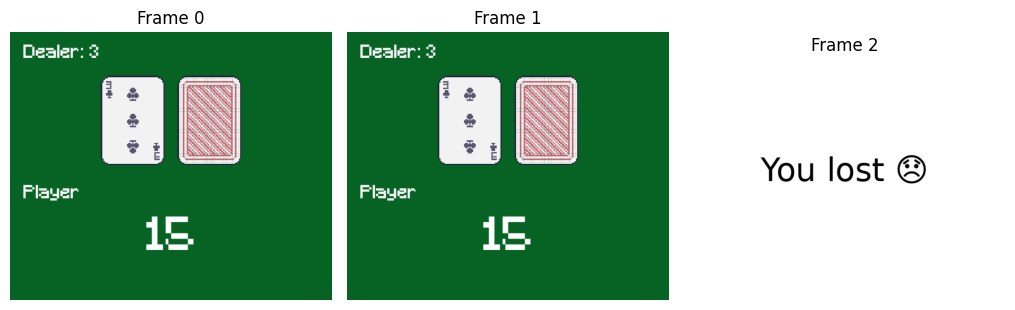

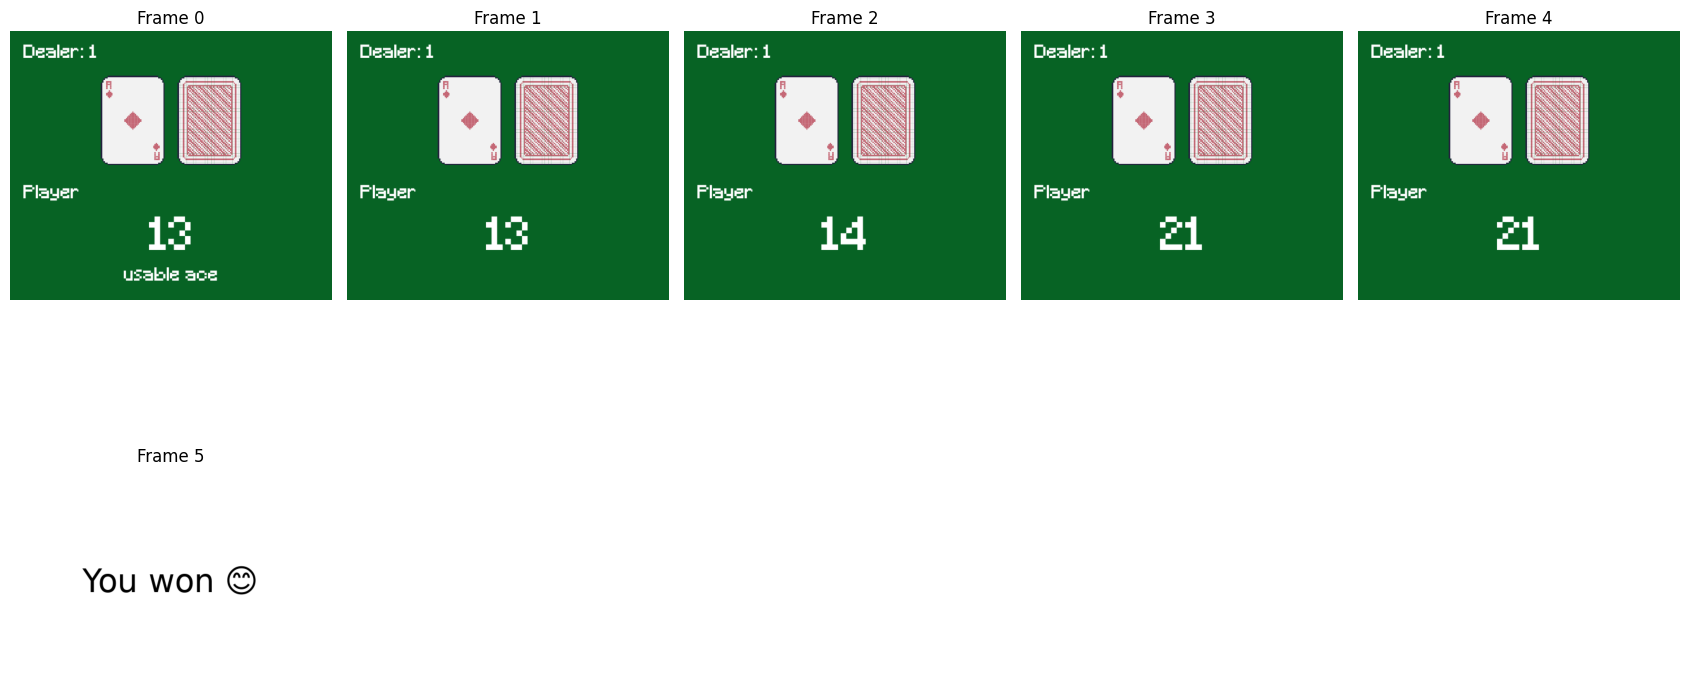

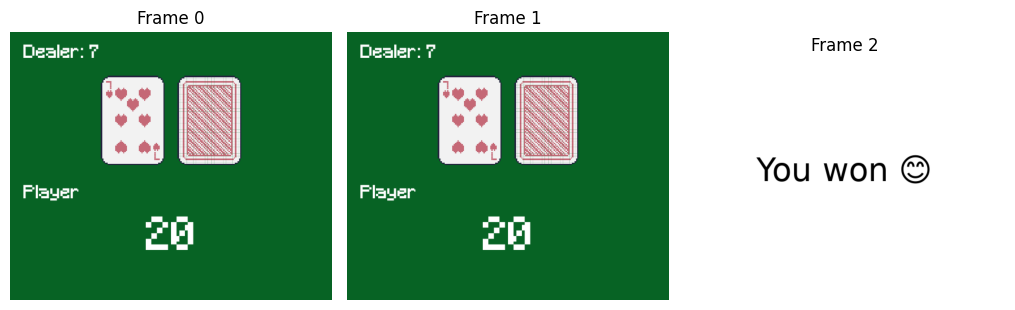

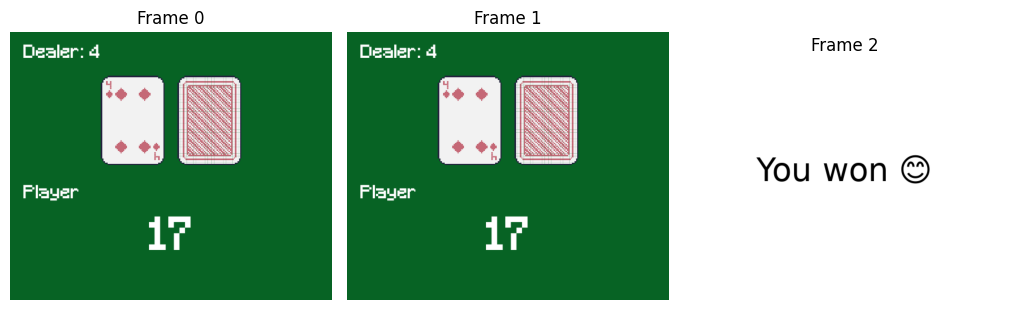

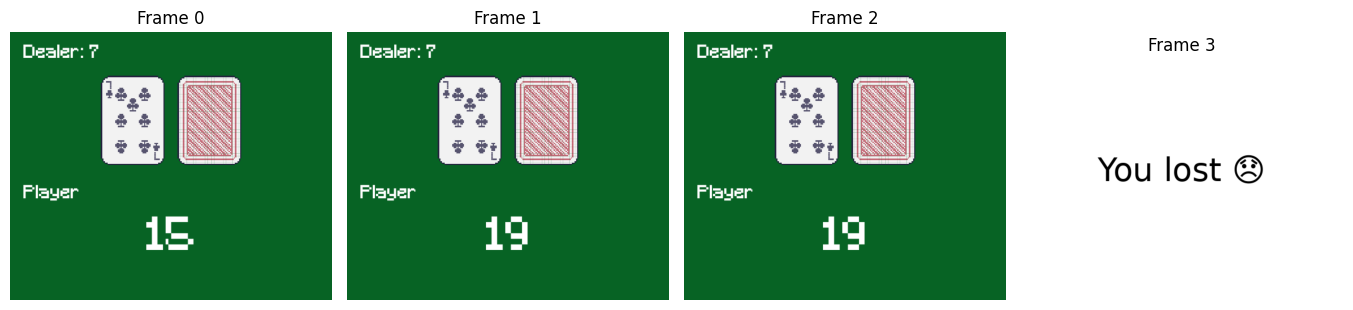

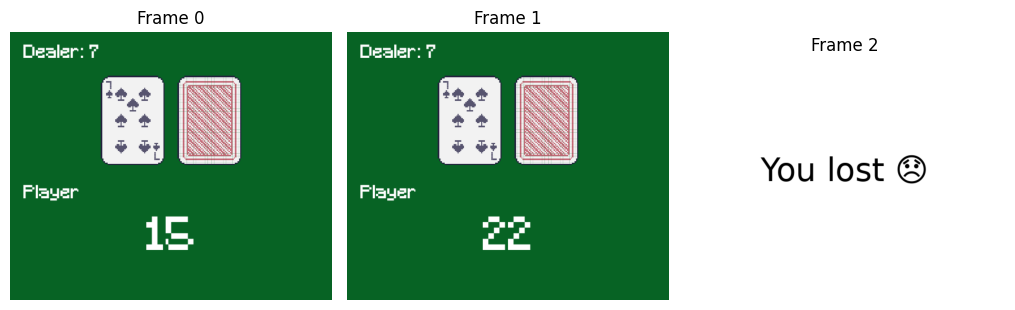

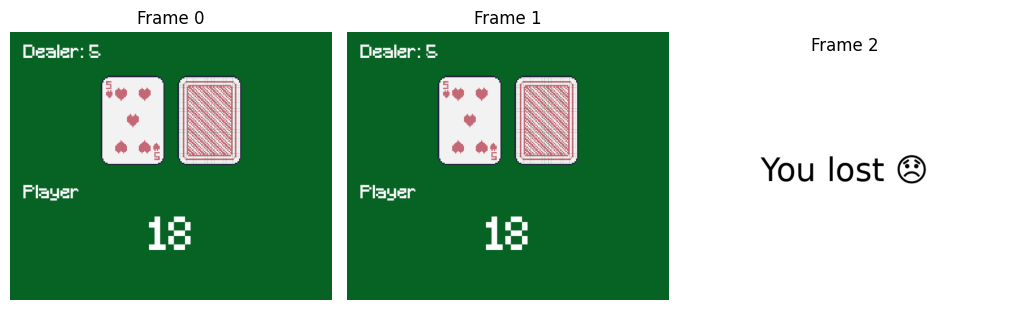

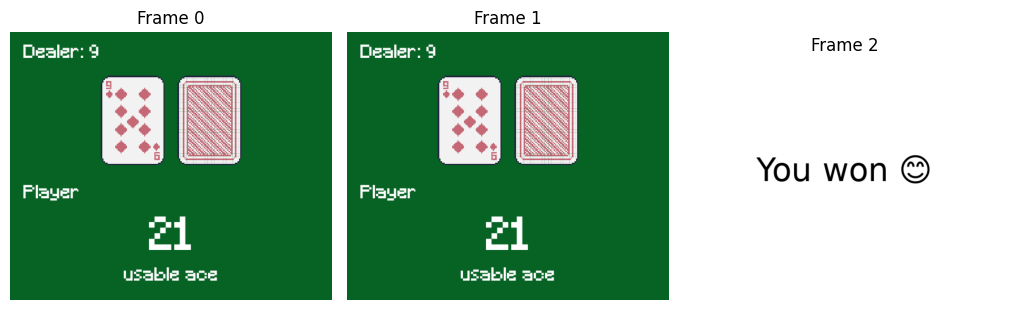

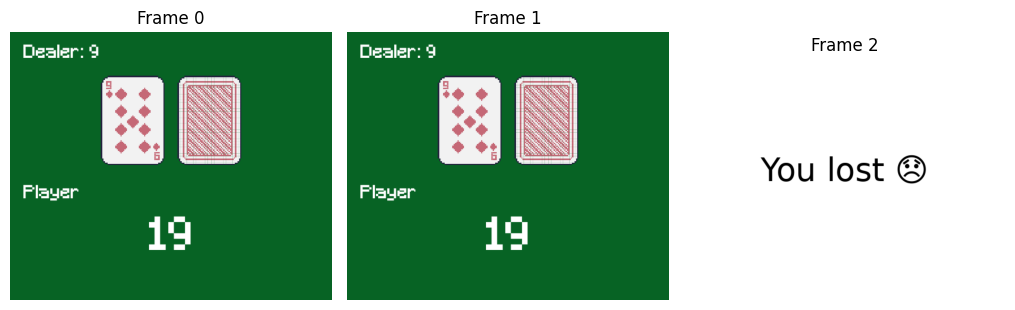

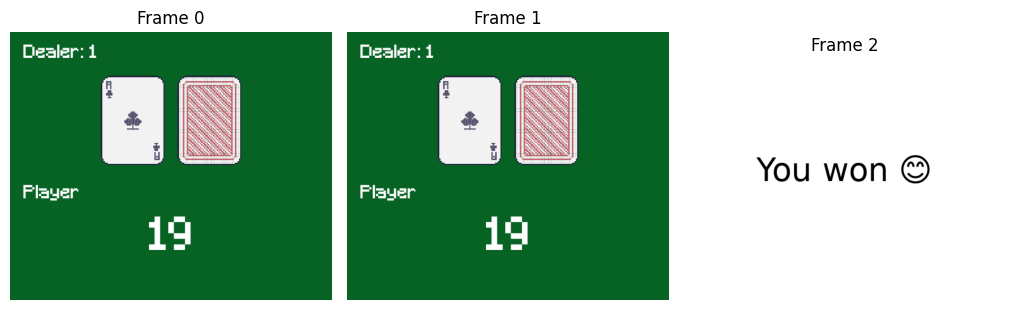

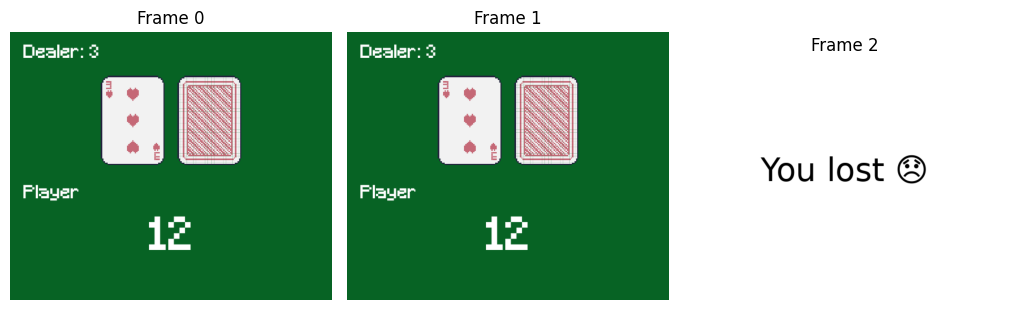

In [8]:
"""
    Blackjack with a learned policy Don't use it with more than 100 examples (heavy print)

"""
won = 0
lost = 0
draw = 0
frames = []
env = gym.make('Blackjack-v1',render_mode='rgb_array')

for i_episode in range(100):
    state, _ = env.reset()
    frames.append(env.render())
    
    while True:

        action = policy.get(state, 0)
        state, reward, done, truncated, info = env.step(action)
        frames.append(env.render())
        if done:
            # Add result card
            if reward > 0:
                result_text = "You won 😊"
                won += 1
            elif reward == 0:
                result_text = "Draw 😐"
                draw += 1
            else:
                result_text = "You lost 😞"
                lost += 1

            frames.append(create_text_frame(result_text))  # Add result as last frame

            # Show frames grid
            show_frames_grid(frames, cols=5)
            frames = []
            break


In [9]:
"""
    Blackjack with a learned policy Testing Accuracy with 1Mio plays

"""
won = 0
lost = 0
draw = 0
frames = []
env = gym.make('Blackjack-v1')

for i_episode in range(1000000):
    state, _ = env.reset()
    
    while True:

        action = policy.get(state, 0)
        state, reward, done, truncated, info = env.step(action)
        if done:
            # Add result card
            if reward > 0:
                won += 1
            elif reward == 0:
                draw += 1
            else:
                lost += 1

            break
print(f"Total episodes: {i_episode+1} Won: {(won/i_episode):.2%}, Lost: {(lost/i_episode):.2%}, Draw: {(draw/i_episode):.2%}")

Total episodes: 1000000 Won: 43.40%, Lost: 47.80%, Draw: 8.80%


In [10]:
print(f"Total episodes: {i_episode+1} Won: {(won/i_episode):.2%}, Lost: {(lost/i_episode):.2%}, Draw: {(draw/i_episode):.2%}")

Total episodes: 1000000 Won: 43.40%, Lost: 47.80%, Draw: 8.80%


Results on 100000 eps with epsilon minimal threshold of 0.15, 0.2

0.15 Total episodes: 1000000 Won: 43.44%, Lost: 47.81%, Draw: 8.76% <br>
0.2  Total episodes: 1000000 Won: 43.50%, Lost: 47.75%, Draw: 8.75% <br>
con epsilon 0.99 <br> 
0.2  <br>

In [11]:
import session_info
session_info.show(html=False)

-----
PIL                 10.4.0
gymnasium           1.0.0
matplotlib          3.9.1
mpl_toolkits        NA
numpy               1.26.4
session_info        1.0.0
-----
IPython             8.26.0
jupyter_client      8.6.2
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
Linux-6.6.87.1-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-06-07 18:37
